# Projeto Integrador 2

## Estudo de Caso: DeliverEase 

A empresa fictícia DeliverEase, uma plataforma de entrega de 
alimentos que opera em diversos estados do país. 

- A empresa processa, em média, 10.000 pedidos diários, conectando clientes a 
restaurantes e fornecedores locais. 
- O maior desafio atual é a imprecisão na previsão do tempo de entrega, que gera: 
    - atrasos inesperados, 
    - insatisfação dos clientes, 
    - aumento no volume de reclamações, 
    - 15% de taxa de cancelamento. 

Além do impacto direto na experiência do usuário, a empresa estima um custo médio de R$ 
1,00 por minuto de atraso. O modelo atual apresenta um erro médio absoluto de 10 minutos, o 
que representa perdas financeiras relevantes e danos à reputação da marca. 
Diante deste cenário, o cientista de dados sênior da DeliverEase foi convocado pelo 
CEO para investigar e propor uma solução mais robusta para o problema de previsão do 
tempo de entrega.

## Imports:

In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from boruta import BorutaPy
from IPython.display import Image, HTML
from datetime import datetime
from geopy.distance import geodesic
from sklearn.preprocessing import RobustScaler, LabelEncoder, MinMaxScaler
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from bayes_opt import BayesianOptimization

## Dataset:

In [87]:
df_raw = pd.read_csv("../data/data_delivery.csv")

## 1.0 Descrição dos Dados:

In [88]:
df1 = df_raw.copy()

### 1.1 Dimensão dos Dados

In [4]:
print("Quantidade de linhas: {}".format(df1.shape[0]))
print("Quantidade de colunas: {}".format(df1.shape[1]))

Quantidade de linhas: 45593
Quantidade de colunas: 20


### 1.2 Tipos dos Dados

In [5]:
df1.dtypes

ID                              object
Delivery_person_ID              object
Delivery_person_Age            float64
Delivery_person_Ratings        float64
Restaurant_latitude            float64
Restaurant_longitude           float64
Delivery_location_latitude     float64
Delivery_location_longitude    float64
Order_Date                      object
Time_Orderd                     object
Time_Order_picked               object
Weatherconditions               object
Road_traffic_density            object
Vehicle_condition                int64
Type_of_order                   object
Type_of_vehicle                 object
multiple_deliveries            float64
Festival                        object
City                            object
Time_taken(min)                 object
dtype: object

### 1.3 Checando os Dados Nulos

In [6]:
df1.isna().sum()

ID                                0
Delivery_person_ID                0
Delivery_person_Age               0
Delivery_person_Ratings           0
Restaurant_latitude               0
Restaurant_longitude              0
Delivery_location_latitude        0
Delivery_location_longitude       0
Order_Date                        0
Time_Orderd                    1731
Time_Order_picked                 0
Weatherconditions                 0
Road_traffic_density              0
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
multiple_deliveries               0
Festival                          0
City                              0
Time_taken(min)                   0
dtype: int64

### 1.4 Tratando os Dados Nulos

In [7]:
# Ajustando as colunas de data e hora para o tipo certo
df1['Order_Date'] = pd.to_datetime(df1['Order_Date'], errors='coerce')
df1['Time_Orderd'] = pd.to_datetime(df1['Time_Orderd'], errors='coerce').dt.time
df1['Time_Order_picked'] = pd.to_datetime(df1['Time_Order_picked'], errors='coerce').dt.time

# Combinando colunas (mantendo hora e data juntos)
df1['ordered_date_time'] = df1.apply(
    lambda row: datetime.combine(row['Order_Date'].date(), row['Time_Orderd'])
    if pd.notnull(row['Order_Date']) and pd.notnull(row['Time_Orderd']) else pd.NaT,
    axis=1
)

df1['order_picked_date_time'] = df1.apply(
    lambda row: datetime.combine(row['Order_Date'].date(), row['Time_Order_picked'])
    if pd.notnull(row['Order_Date']) and pd.notnull(row['Time_Order_picked']) else pd.NaT,
    axis=1
)

# Coluna de diferença de datas
df1['time_diff'] = df1['ordered_date_time'] - df1['order_picked_date_time'] 

#mediana:
median_diff = df1['time_diff'].median()

#inserindo a mediana da diferença de tempo para os dados nulos:
df1['ordered_date_time'] = df1.apply(
    lambda row: row['order_picked_date_time'] + median_diff 
    if pd.isnull(row['ordered_date_time'])
    else row['ordered_date_time'],
    axis =1
)

df1['Time_Orderd'] = df1['ordered_date_time']
df1['Time_Order_picked'] = df1['order_picked_date_time'] 

df1.drop(columns = ['time_diff', 'ordered_date_time', 'order_picked_date_time'], inplace = True)

C:\Users\samso\AppData\Local\Temp\ipykernel_24060\853991514.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df1['Time_Orderd'] = pd.to_datetime(df1['Time_Orderd'], errors='coerce').dt.time
C:\Users\samso\AppData\Local\Temp\ipykernel_24060\853991514.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df1['Time_Order_picked'] = pd.to_datetime(df1['Time_Order_picked'], errors='coerce').dt.time


### 1.5 Ajustando os Tipos de Dados

In [8]:
#função para extrair o valor da variável resposta:

def extrair_valor(texto):
    match = re.search(r'\d+', texto)
    if match:
        return int(match.group())
    else:
        return None

#extraindo o valor:
df1['Time_taken(min)'] = df1['Time_taken(min)'].apply(extrair_valor)

### 1.6 Estatística Descritiva

In [9]:
#variáveis numéricas:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])

#variáveis categóricas:
cat_attributes = df1.select_dtypes(include = ['object'])

#### 1.6.1 Dados Numéricos

In [10]:
#medidas de tendência central:

ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T     #média
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T   #mediana

#medidas de dispersão:
d1 = pd.DataFrame(num_attributes.apply(np.std)).T                               #desvio-padrão
d2 = pd.DataFrame(num_attributes.apply(min)).T                                  #mínimo
d3 = pd.DataFrame(num_attributes.apply(max)).T                                  #máximo
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T          #range
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T                   #assimetria
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T               #curtose

#concatenar:
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m


attributes        min        max       range       mean  \
0          Delivery_person_Age  18.000000  50.000000   32.000000  29.424583   
1      Delivery_person_Ratings   1.000000   6.000000    5.000000   4.636552   
2          Restaurant_latitude -30.905562  30.914057   61.819619  17.017729   
3         Restaurant_longitude -88.366217  88.433452  176.799669  70.231332   
4   Delivery_location_latitude   0.010000  31.054057   31.044057  17.465186   
5  Delivery_location_longitude   0.010000  88.563452   88.553452  70.845702   
6            Vehicle_condition   0.000000   3.000000    3.000000   1.023359   
7          multiple_deliveries   0.000000   3.000000    3.000000   0.750225   
8              Time_taken(min)  10.000000  54.000000   44.000000  26.294607   

      median        std      skew   kurtosis  
0  29.000000   5.733407  0.090328  -1.038405  
1   4.700000   0.327902 -2.566185  16.508814  
2  18.546947   8.185019 -1.361583   3.713716  
3  75.898497  22.883396 -3.220159  10.303039  
4  18.633934   7.335042 -0.701066   0.264346  
5  76.002574  21.118580 -2.956385   7.104451  
6   1.000000   0.839056  0.071853  -1.315002  
7   1.000000   0.567424  0.298735   0.950328  
8  26.000000   9.383703  0.485951  -0.310798

#### 1.6.2 Dados Categóricos

In [11]:
cat_attributes.describe().T

count unique                top   freq
ID                    45593  45593            0x4607       1
Delivery_person_ID    45593   1320    PUNERES01DEL01      67
Weatherconditions     45593      6  conditions Cloudy   8152
Road_traffic_density  45593      4               Low   16078
Type_of_order         45593      4             Snack   11533
Type_of_vehicle       45593      4        motorcycle   26435
Festival              45593      2                No   44697
City                  45593      3     Metropolitian   35293

## 2.0 Feature Engineering:

In [69]:
df2 = df1.copy()

### 2.1 Mapa Mental de Hipóteses

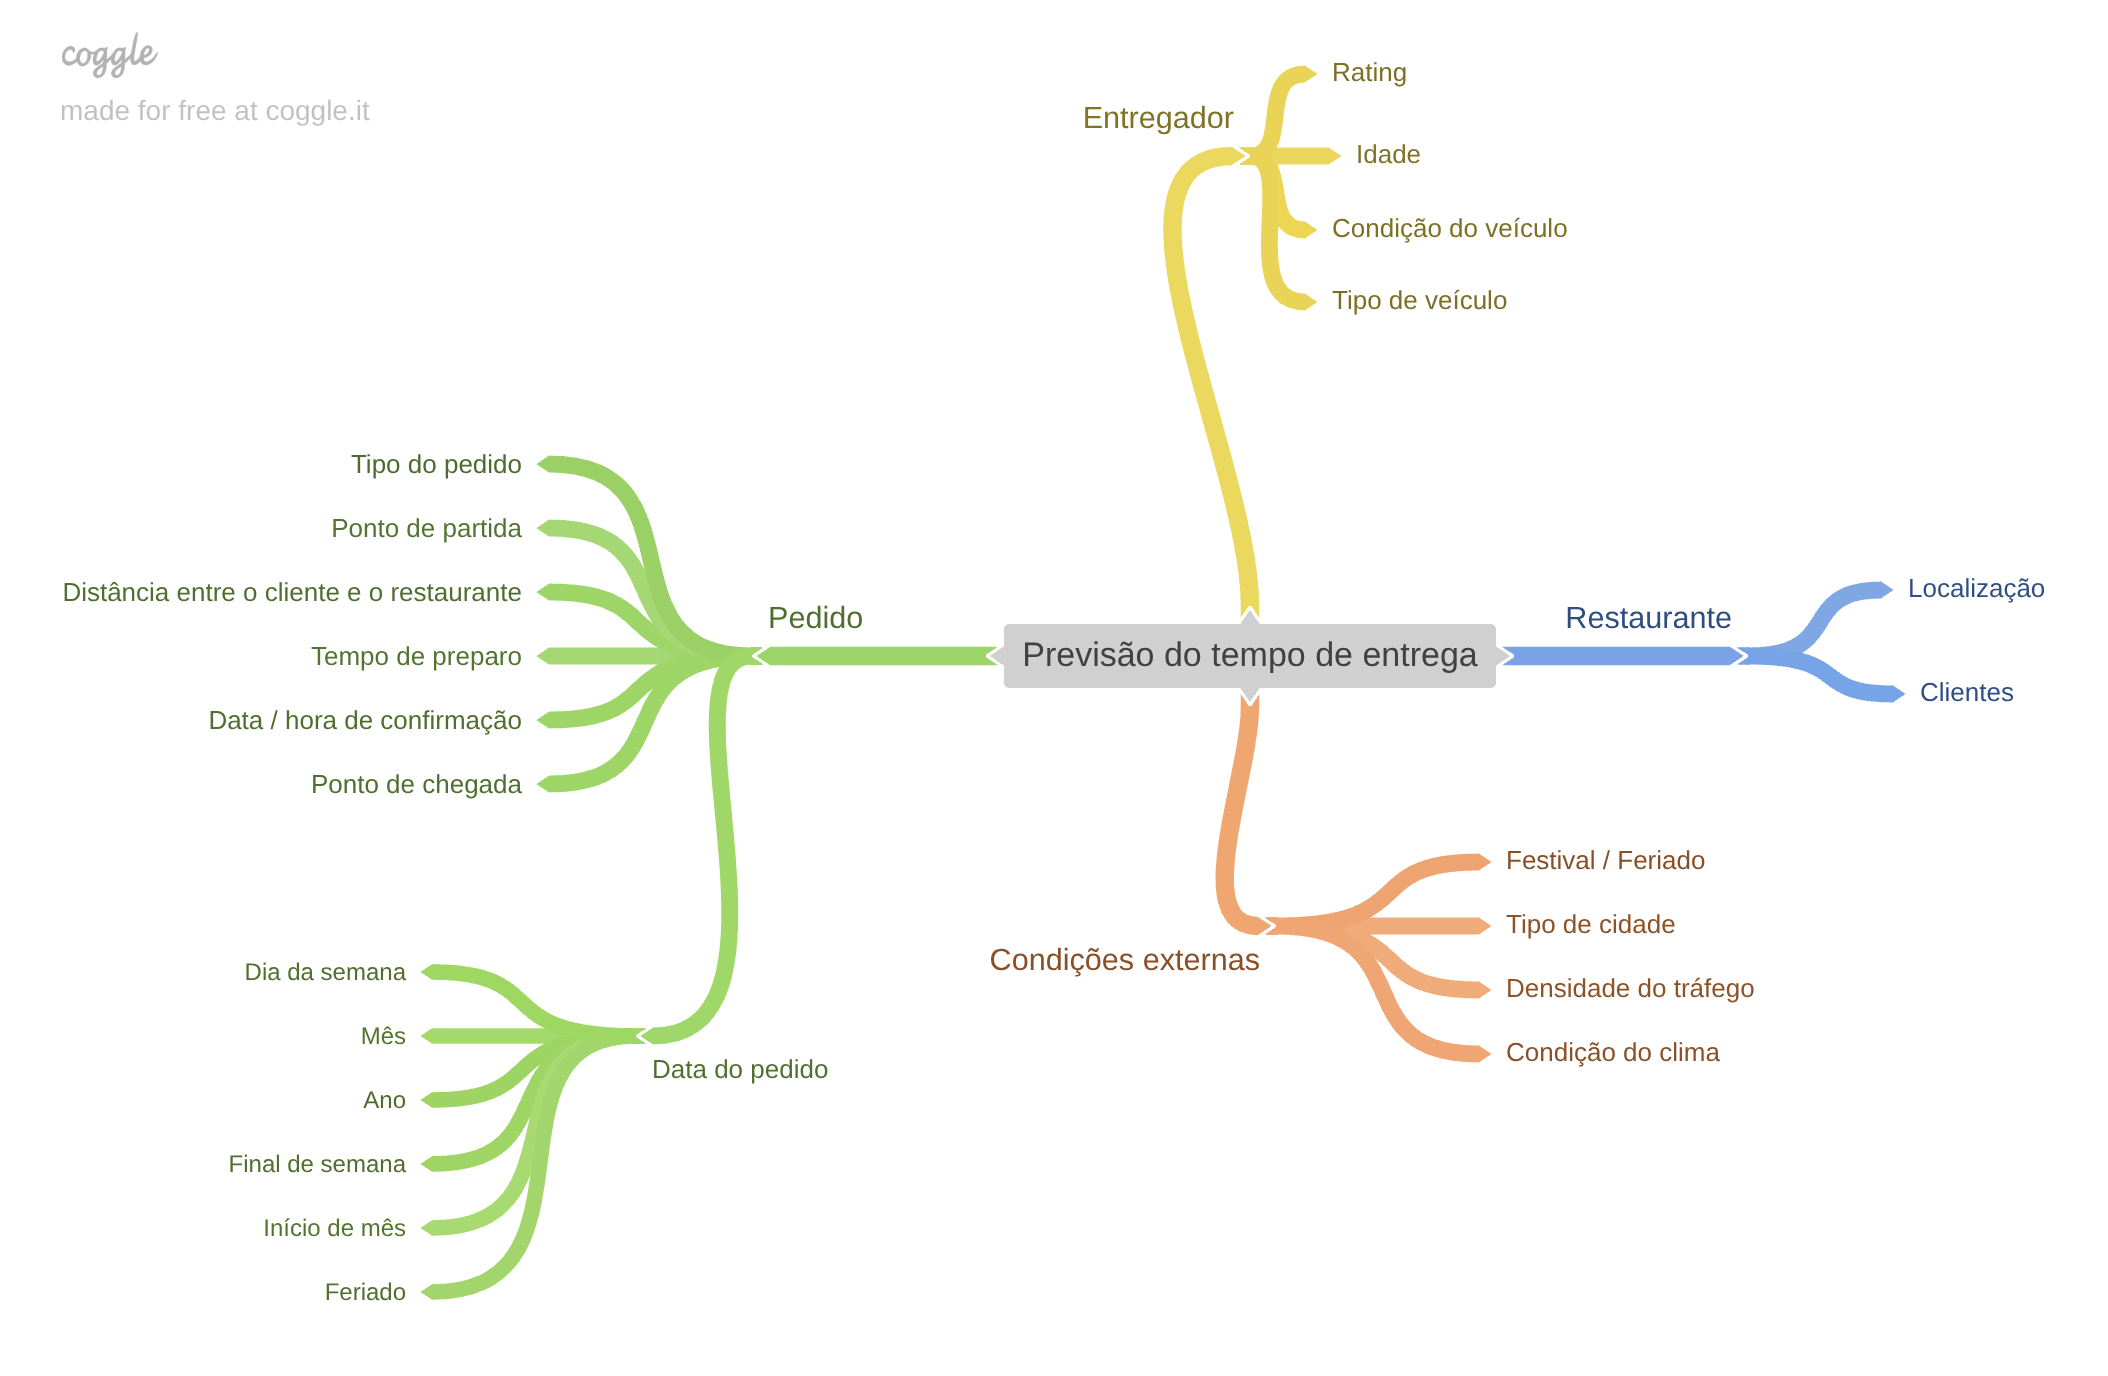

In [13]:
Image('../data/mindmap_hipoteses.png')

### 2.2 Lista de Hipóteses

#### 2.2.1 Hipóteses do Pedido:

- Quanto maior o tempo de preparo do pedido maior o tempo de entrega;

- Quanto maior a distância entre o restaurante e o cliente maior o tempo de entrega;

- Pedidos aos finais de semana possuem maior tempo de entrega;

- Pedidos no começo do mês possuem maior tempo de entrega;

- Tipos específicos de pedidos podem exigir diferentes tempos de entrega;

#### 2.2.2 Hipóteses do Entregador:

- A idade do entregador afeta a velocidade da entrega;

- Avaliações do entregador podem impactar a eficiência da entrega;

- O tipo de veículo usado para a entrega pode impactar no tempo de entrega;

- Múltiplas entregas em uma única rota podem aumentar o tempo de entrega;

- A condição do veículo pode influenciar o tempo de entrega

#### 2.2.3 Hipóteses das Condições Externas:

-  Condições climáticas adversas podem aumentar o tempo de entrega;

- A densidade do tráfego pode impactar o tempo de entrega;

- Festivais ou eventos na cidade podem afetar o tempo de entrega

### 2.3 Feature Engineering

In [14]:
#criando novas colunas de dia, mês, trimestre, ano, início e fim de mês, de semestre, de ano, fim de semana:

df2['day'] = df2.Order_Date.dt.day
df2['month'] = df2.Order_Date.dt.month
df2['quarter'] = df2.Order_Date.dt.quarter
df2['year'] = df2.Order_Date.dt.year
df2['day_of_week'] = df2.Order_Date.dt.day_of_week.astype(int)
df2['is_month_start'] = df2.Order_Date.dt.is_month_start.astype(int)
df2['is_month_end'] = df2.Order_Date.dt.is_month_end.astype(int)
df2['is_quarter_start'] = df2.Order_Date.dt.is_quarter_start.astype(int)
df2['is_quarter_end'] = df2.Order_Date.dt.is_quarter_end.astype(int)
df2['is_year_start'] = df2.Order_Date.dt.is_year_start.astype(int)
df2['is_year_end'] = df2.Order_Date.dt.is_year_end.astype(int)
df2['is_weekend'] = np.where(df2['day_of_week'].isin([5,6]),1,0)

In [15]:
#funções:

#tempo de preparo do pedido:

def calculate_time_diff(df):
    time_diff = df['Time_Order_picked'] - df['Time_Orderd']
    time_diff = time_diff.apply(lambda x: x + pd.Timedelta(days=1) if x.days <0 else x)
    df['order_prepare_time'] = time_diff.dt.total_seconds()/60
    df['order_prepare_time'].fillna(df['order_prepare_time'].median(), inplace = True)

calculate_time_diff(df2)

In [16]:
#diferença da distância:

def calculate_distance(df):
    df['distance'] = np.zeros(len(df))
    restaurante_coordinates = df[['Restaurant_latitude','Restaurant_longitude']].to_numpy()
    cliente_coordinates = df[['Delivery_location_latitude','Delivery_location_longitude']].to_numpy()
    df['distance'] = np.array([geodesic(restaurant, delivery) for restaurant, delivery in zip(restaurante_coordinates, cliente_coordinates)])
    df['distance'] = df['distance'].astype('str').str.extract('(\d+)').astype('int64')

calculate_distance(df2)

In [17]:
df2.head()

ID Delivery_person_ID  Delivery_person_Age  Delivery_person_Ratings  \
0  0x4607     INDORES13DEL02                  37.0                      4.9   
1  0xb379     BANGRES18DEL02                  34.0                      4.5   
2  0x5d6d     BANGRES19DEL01                  23.0                      4.4   
3  0x7a6a    COIMBRES13DEL02                  38.0                      4.7   
4  0x70a2     CHENRES12DEL01                  32.0                      4.6   

   Restaurant_latitude  Restaurant_longitude  Delivery_location_latitude  \
0            22.745049             75.892471                   22.765049   
1            12.913041             77.683237                   13.043041   
2            12.914264             77.678400                   12.924264   
3            11.003669             76.976494                   11.053669   
4            12.972793             80.249982                   13.012793   

   Delivery_location_longitude Order_Date         Time_Orderd  ...  \
0                    75.912471 2022-03-19 2022-03-19 11:30:00  ...   
1                    77.813237 2022-03-25 2022-03-25 19:45:00  ...   
2                    77.688400 2022-03-19 2022-03-19 08:30:00  ...   
3                    77.026494 2022-04-05 2022-04-05 18:00:00  ...   
4                    80.289982 2022-03-26 2022-03-26 13:30:00  ...   

  day_of_week is_month_start is_month_end  is_quarter_start is_quarter_end  \
0           5              0            0                 0              0   
1           4              0            0                 0              0   
2           5              0            0                 0              0   
3           1              0            0                 0              0   
4           5              0            0                 0              0   

  is_year_start  is_year_end is_weekend order_prepare_time  distance  
0             0            0          1               15.0         3  
1             0            0          0                5.0        20  
2             0            0          1               15.0         1  
3             0            0          0               10.0         7  
4             0            0          1               15.0         6  

[5 rows x 34 columns]

## 3.0 Filtragem dos Dados

In [18]:
df3 = df2.copy()

#### 3.1 Filtragem de Linhas

#### 3.2 Filtragem de Colunas

In [19]:
df3 = df3.drop(columns = ['ID', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Order_Date', 'Time_Orderd',
       'Time_Order_picked'])

## 4.0 Análise Exploratória de Dados:

In [20]:
df4 = df3.copy()

### 4.1 Análise Univariada

#### 4.1.1 Variável Resposta

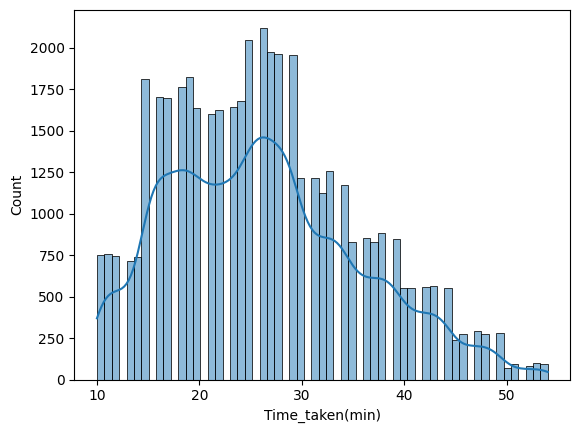

In [21]:
#variável resposta

sns.histplot(df4['Time_taken(min)'], kde=True)
plt.show()

#### 4.1.2 Variáveis Numéricas

In [22]:
def jupyter_settings():
    %matplotlib inline

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [30,16]
    plt.rcParams['font.size'] = 24

    display(HTML ('<style>.container {width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)

    sns.set()

jupyter_settings()

In [23]:
#variáveis numéricas:
num_attributes = df4.select_dtypes(include = ['int64', 'float64', 'int32'])

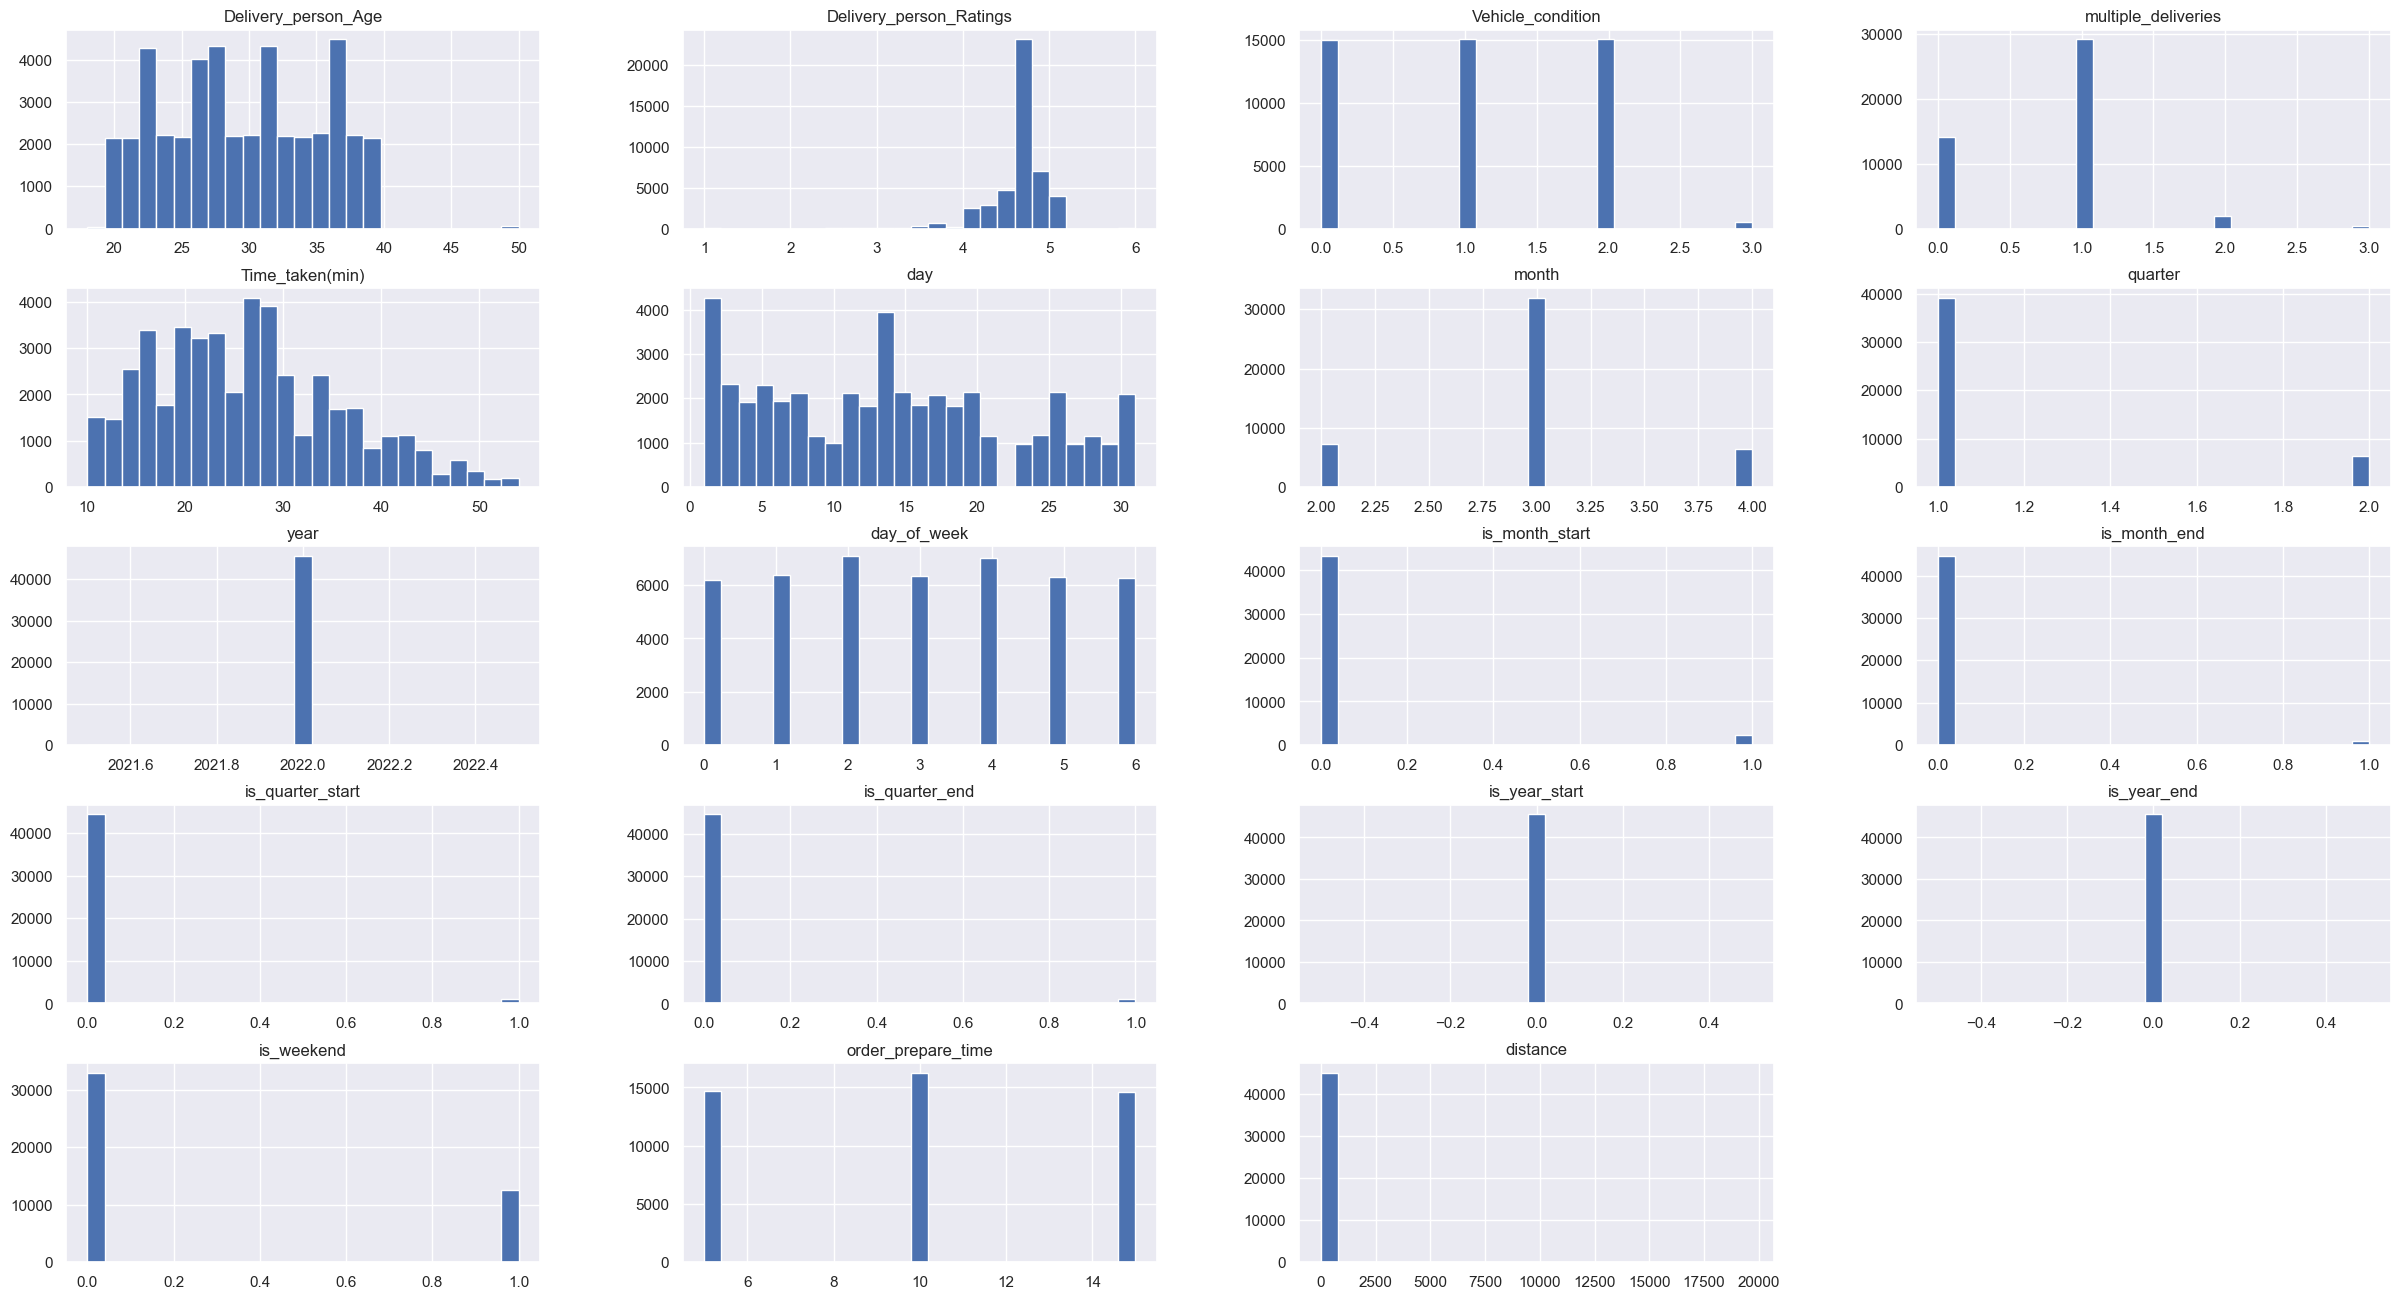

In [24]:
num_attributes.hist(bins = 25);

#### 4.1.3 Variáveis Categóricas

In [25]:
#retirando os espaços:

df4['Road_traffic_density'] = df4['Road_traffic_density'].str.strip()
df4['Type_of_order'] = df4['Type_of_order'].str.strip()
df4['Type_of_vehicle'] = df4['Type_of_vehicle'].str.strip()

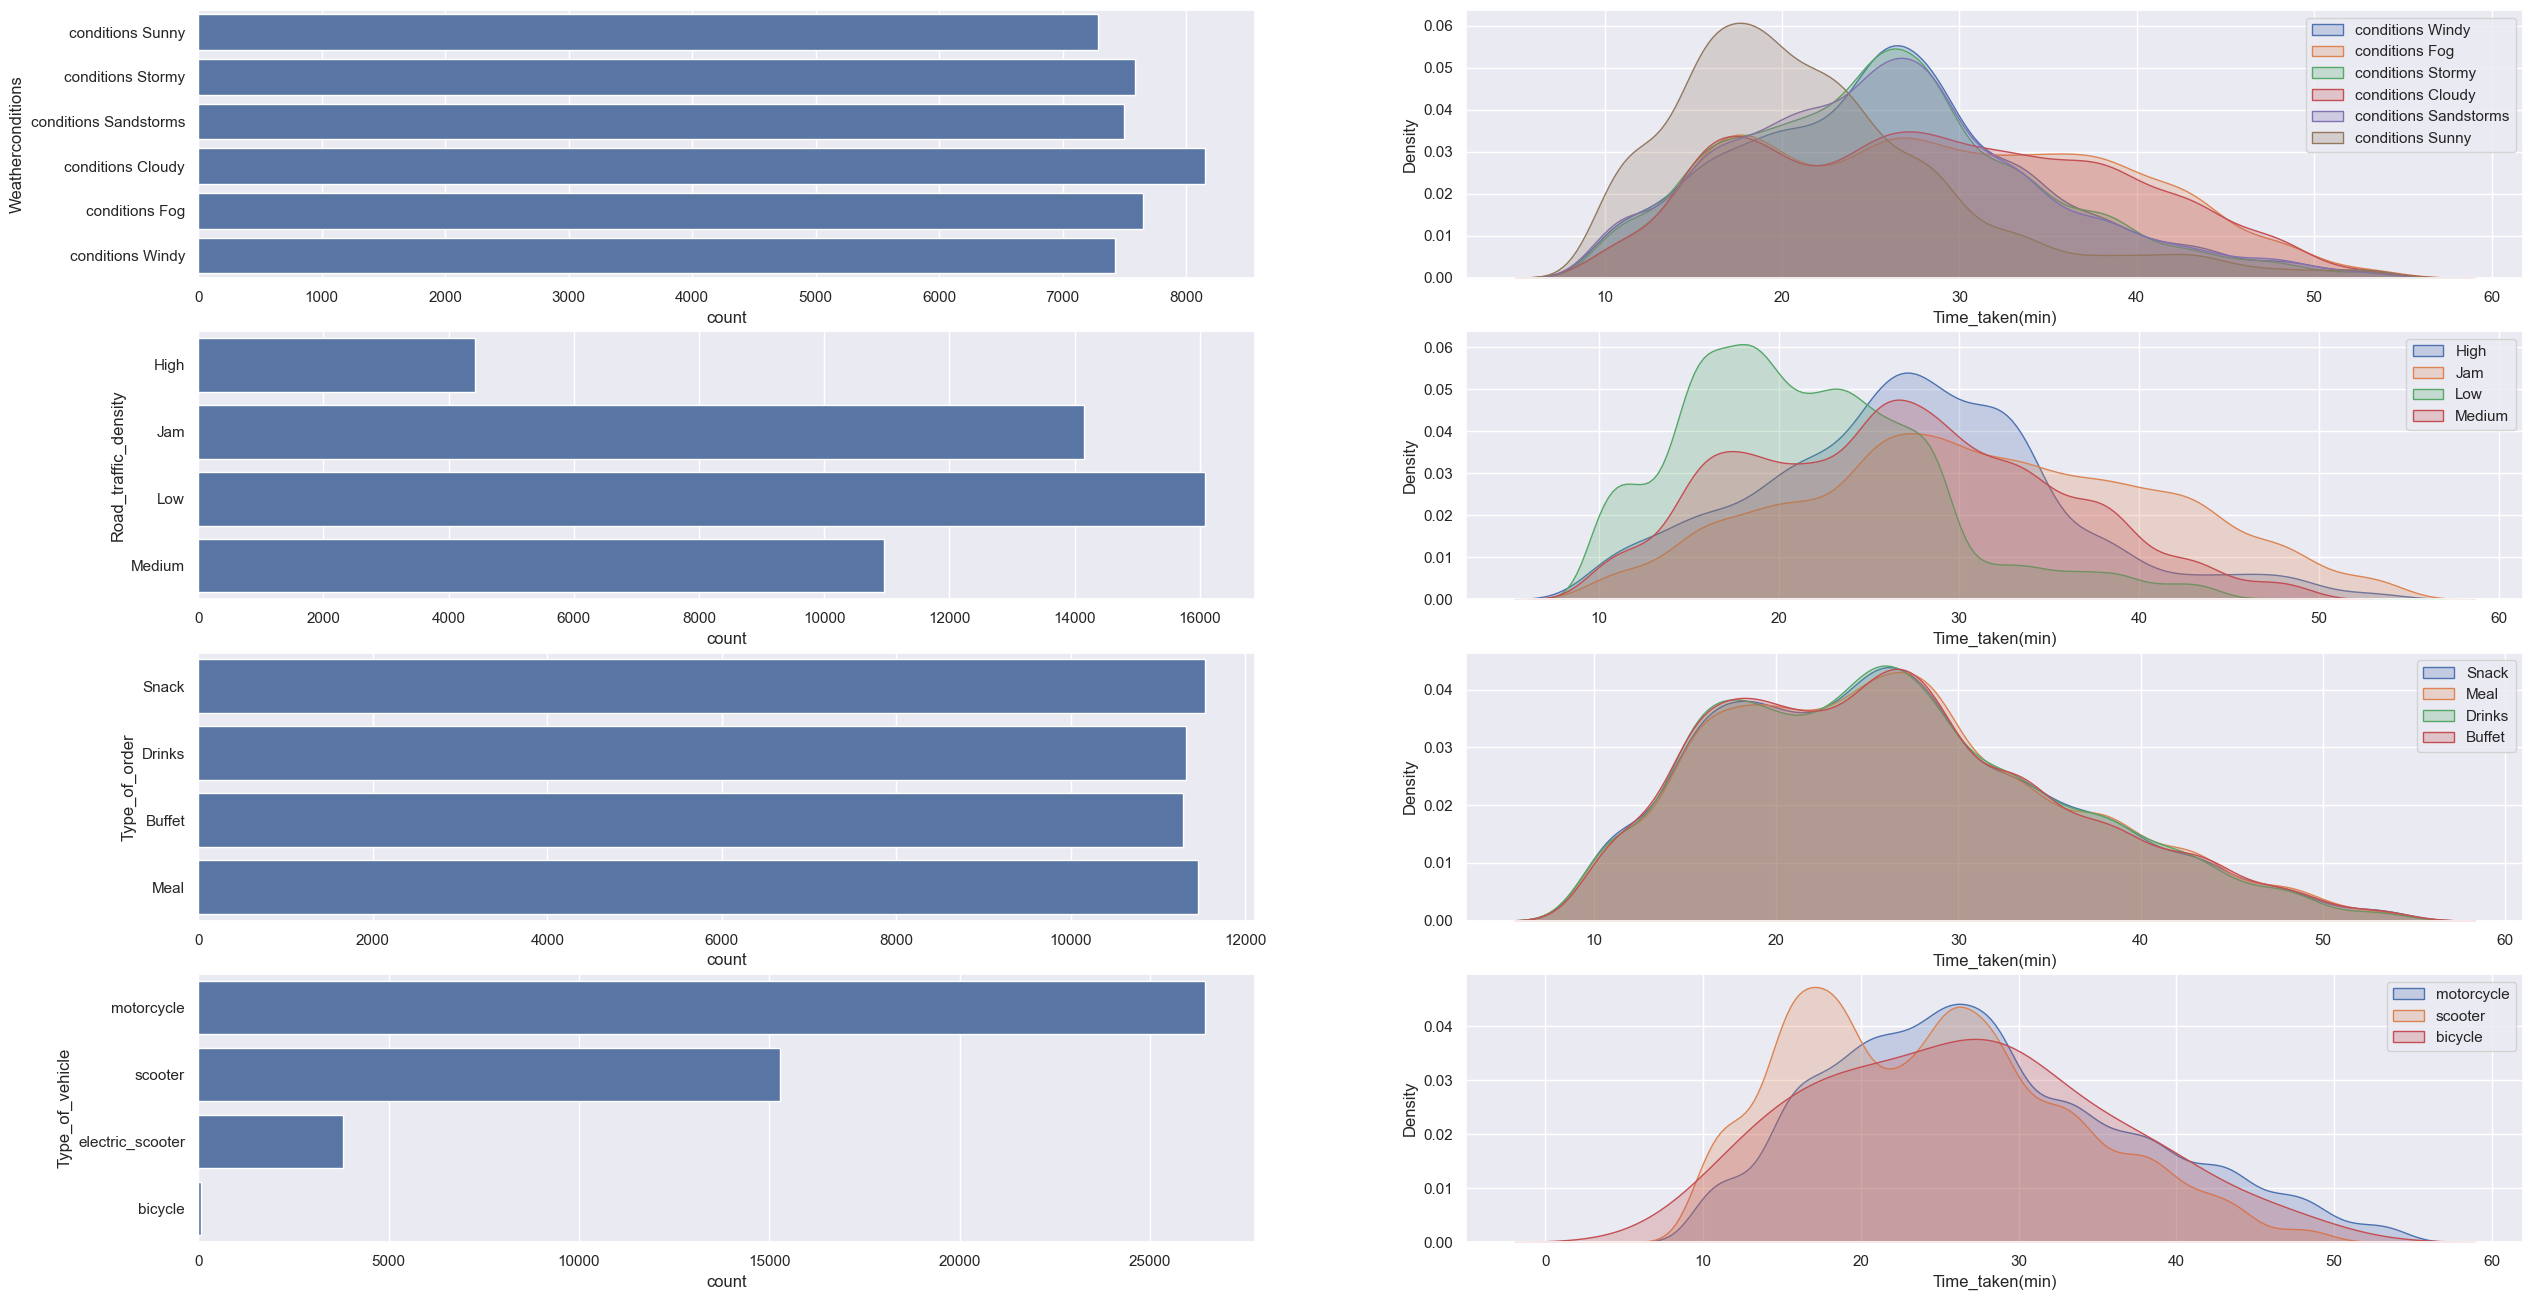

In [26]:
#weatherconditions

plt.subplot(4,2,1)
sns.countplot(df4['Weatherconditions'])

plt.subplot(4,2,2)
sns.kdeplot(df4[df4['Weatherconditions'] == 'conditions Windy']['Time_taken(min)'], label = 'conditions Windy', fill = True)
sns.kdeplot(df4[df4['Weatherconditions'] == 'conditions Fog']['Time_taken(min)'], label = 'conditions Fog', fill = True)
sns.kdeplot(df4[df4['Weatherconditions'] == 'conditions Stormy']['Time_taken(min)'], label = 'conditions Stormy', fill = True)
sns.kdeplot(df4[df4['Weatherconditions'] == 'conditions Cloudy']['Time_taken(min)'], label = 'conditions Cloudy', fill = True)
sns.kdeplot(df4[df4['Weatherconditions'] == 'conditions Sandstorms']['Time_taken(min)'], label = 'conditions Sandstorms', fill = True)
sns.kdeplot(df4[df4['Weatherconditions'] == 'conditions Sunny']['Time_taken(min)'], label = 'conditions Sunny', fill = True)

plt.legend()

#road traffic density

plt.subplot(4,2,3)
sns.countplot(df4['Road_traffic_density'])

plt.subplot(4,2,4)
sns.kdeplot(df4[df4['Road_traffic_density'] == 'High']['Time_taken(min)'], label = 'High', fill = True)
sns.kdeplot(df4[df4['Road_traffic_density'] == 'Jam']['Time_taken(min)'], label = 'Jam', fill = True)
sns.kdeplot(df4[df4['Road_traffic_density'] == 'Low']['Time_taken(min)'], label = 'Low', fill = True)
sns.kdeplot(df4[df4['Road_traffic_density'] == 'Medium']['Time_taken(min)'], label = 'Medium', fill = True)

plt.legend()

#type of order

plt.subplot(4,2,5)
sns.countplot(df4['Type_of_order'])

plt.subplot(4,2,6)
sns.kdeplot(df4[df4['Type_of_order'] == 'Snack']['Time_taken(min)'], label = 'Snack', fill = True)
sns.kdeplot(df4[df4['Type_of_order'] == 'Meal']['Time_taken(min)'], label = 'Meal', fill = True)
sns.kdeplot(df4[df4['Type_of_order'] == 'Drinks']['Time_taken(min)'], label = 'Drinks', fill = True)
sns.kdeplot(df4[df4['Type_of_order'] == 'Buffet']['Time_taken(min)'], label = 'Buffet', fill = True)

plt.legend()

#type of order

plt.subplot(4,2,7)
sns.countplot(df4['Type_of_vehicle'])

plt.subplot(4,2,8)
sns.kdeplot(df4[df4['Type_of_vehicle'] == 'motorcycle']['Time_taken(min)'], label = 'motorcycle', fill = True)
sns.kdeplot(df4[df4['Type_of_vehicle'] == 'scooter']['Time_taken(min)'], label = 'scooter', fill = True)
sns.kdeplot(df4[df4['Type_of_vehicle'] == 'eletric_scooter']['Time_taken(min)'], label = 'eletric_scooter', fill = True)
sns.kdeplot(df4[df4['Type_of_vehicle'] == 'bicycle']['Time_taken(min)'], label = 'bicycle', fill = True)

plt.legend()

### 4.2 Análise Bivariada

#### Hipótese 1: Quanto maior o tempo de preparo do pedido maior o tempo de entrega: 
FALSA. Não há relação.

<Axes: >

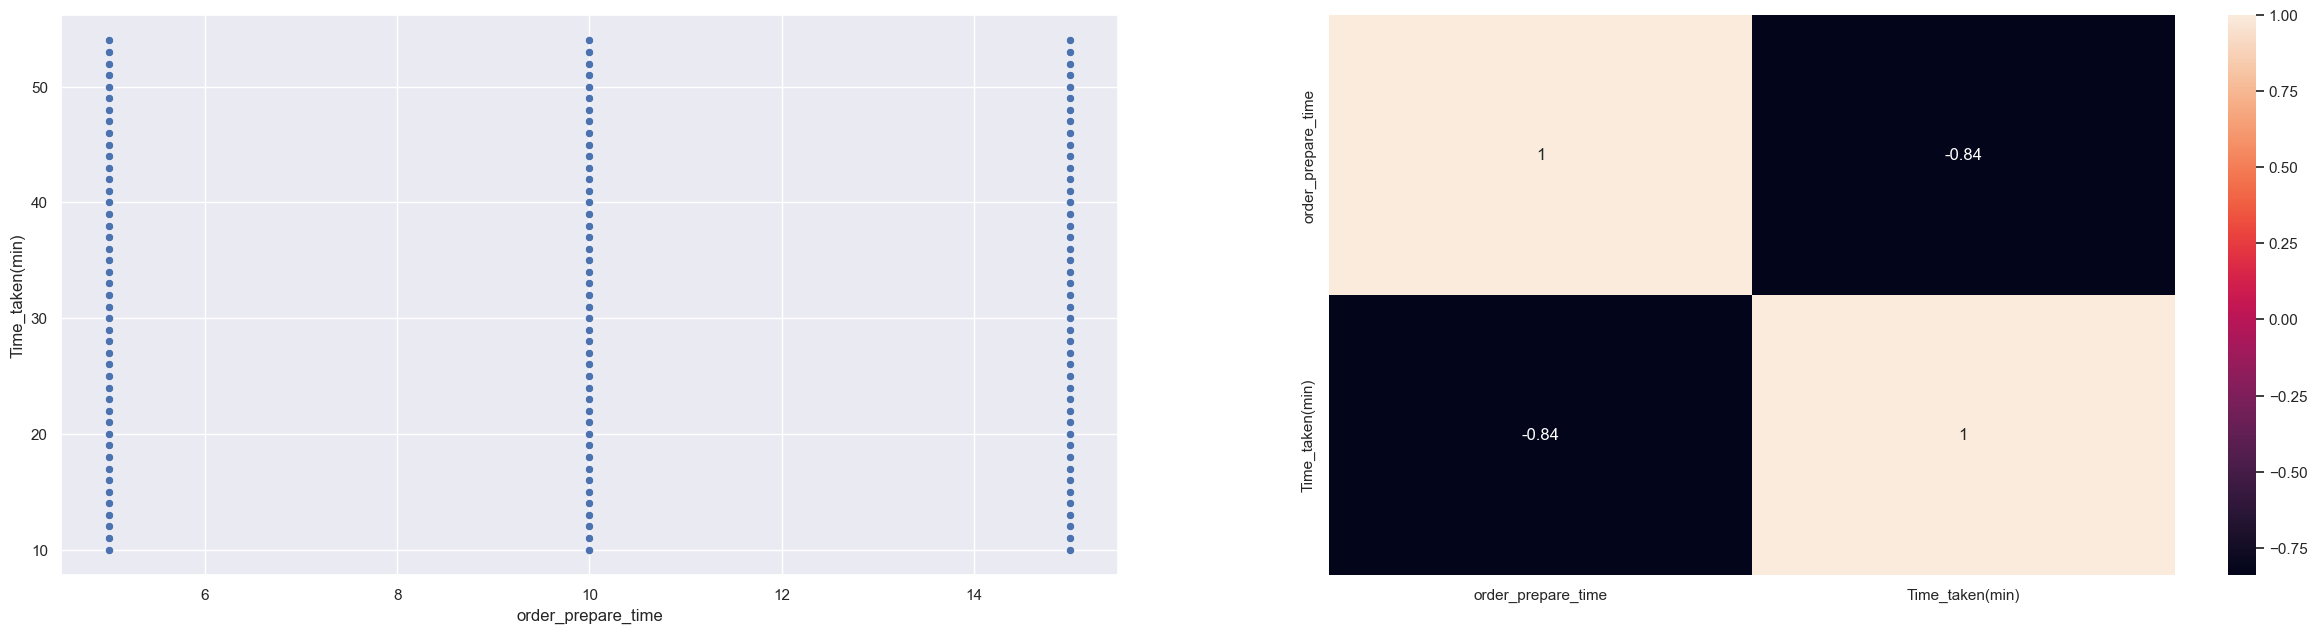

In [27]:
aux1 = df4[['order_prepare_time', 'Time_taken(min)']].groupby('order_prepare_time').mean().reset_index()

grid = GridSpec(2,2)

plt.subplot(grid[0,0])
sns.scatterplot(x = 'order_prepare_time', y = 'Time_taken(min)', data = df4)

plt.subplot(grid[0,1])
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

#### Hipótese 2: Quanto maior a distância entre o restaurante e o cliente maior o tempo de entrega:
FALSA. Não há relação entre a distância e o tempo de entrega

<Axes: >

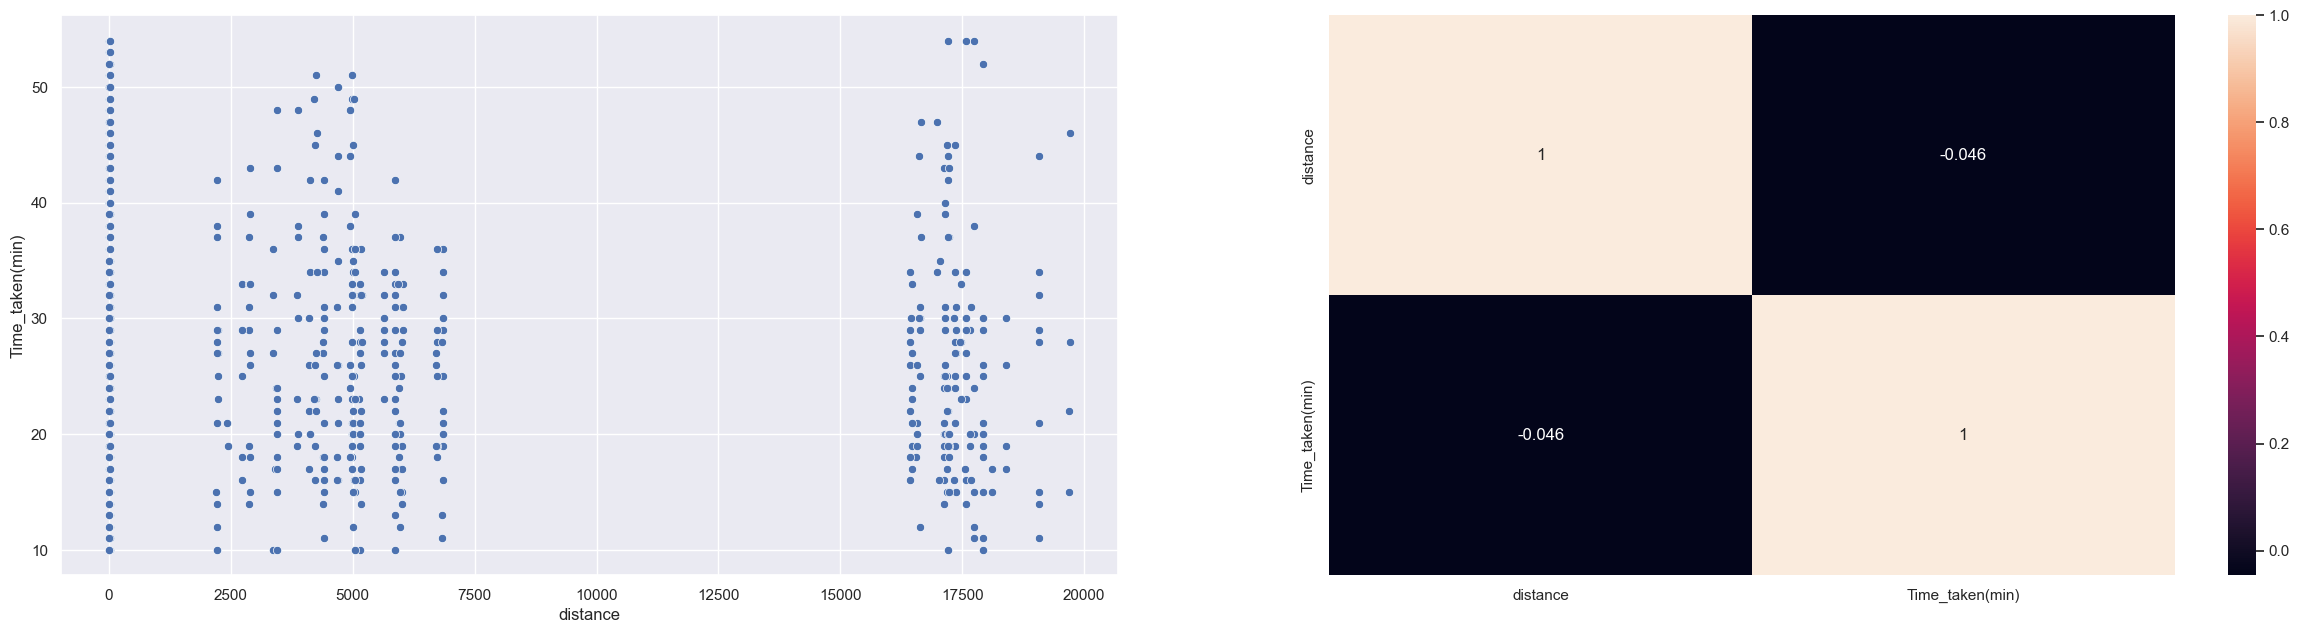

In [28]:
aux2 = df4[['distance', 'Time_taken(min)']].groupby('distance').mean().reset_index()

grid = GridSpec(2,2)

plt.subplot(grid[0,0])
sns.scatterplot(x = 'distance', y = 'Time_taken(min)', data = df4)

plt.subplot(grid[0,1])
sns.heatmap(aux2.corr(method = 'pearson'), annot = True)

#### Hipótese 3: Pedidos aos finais de semana possuem maior tempo de entrega
FALSA:  a média do tempo de entrega é menor aos finais de semana



<Axes: xlabel='is_weekend', ylabel='Time_taken(min)'>

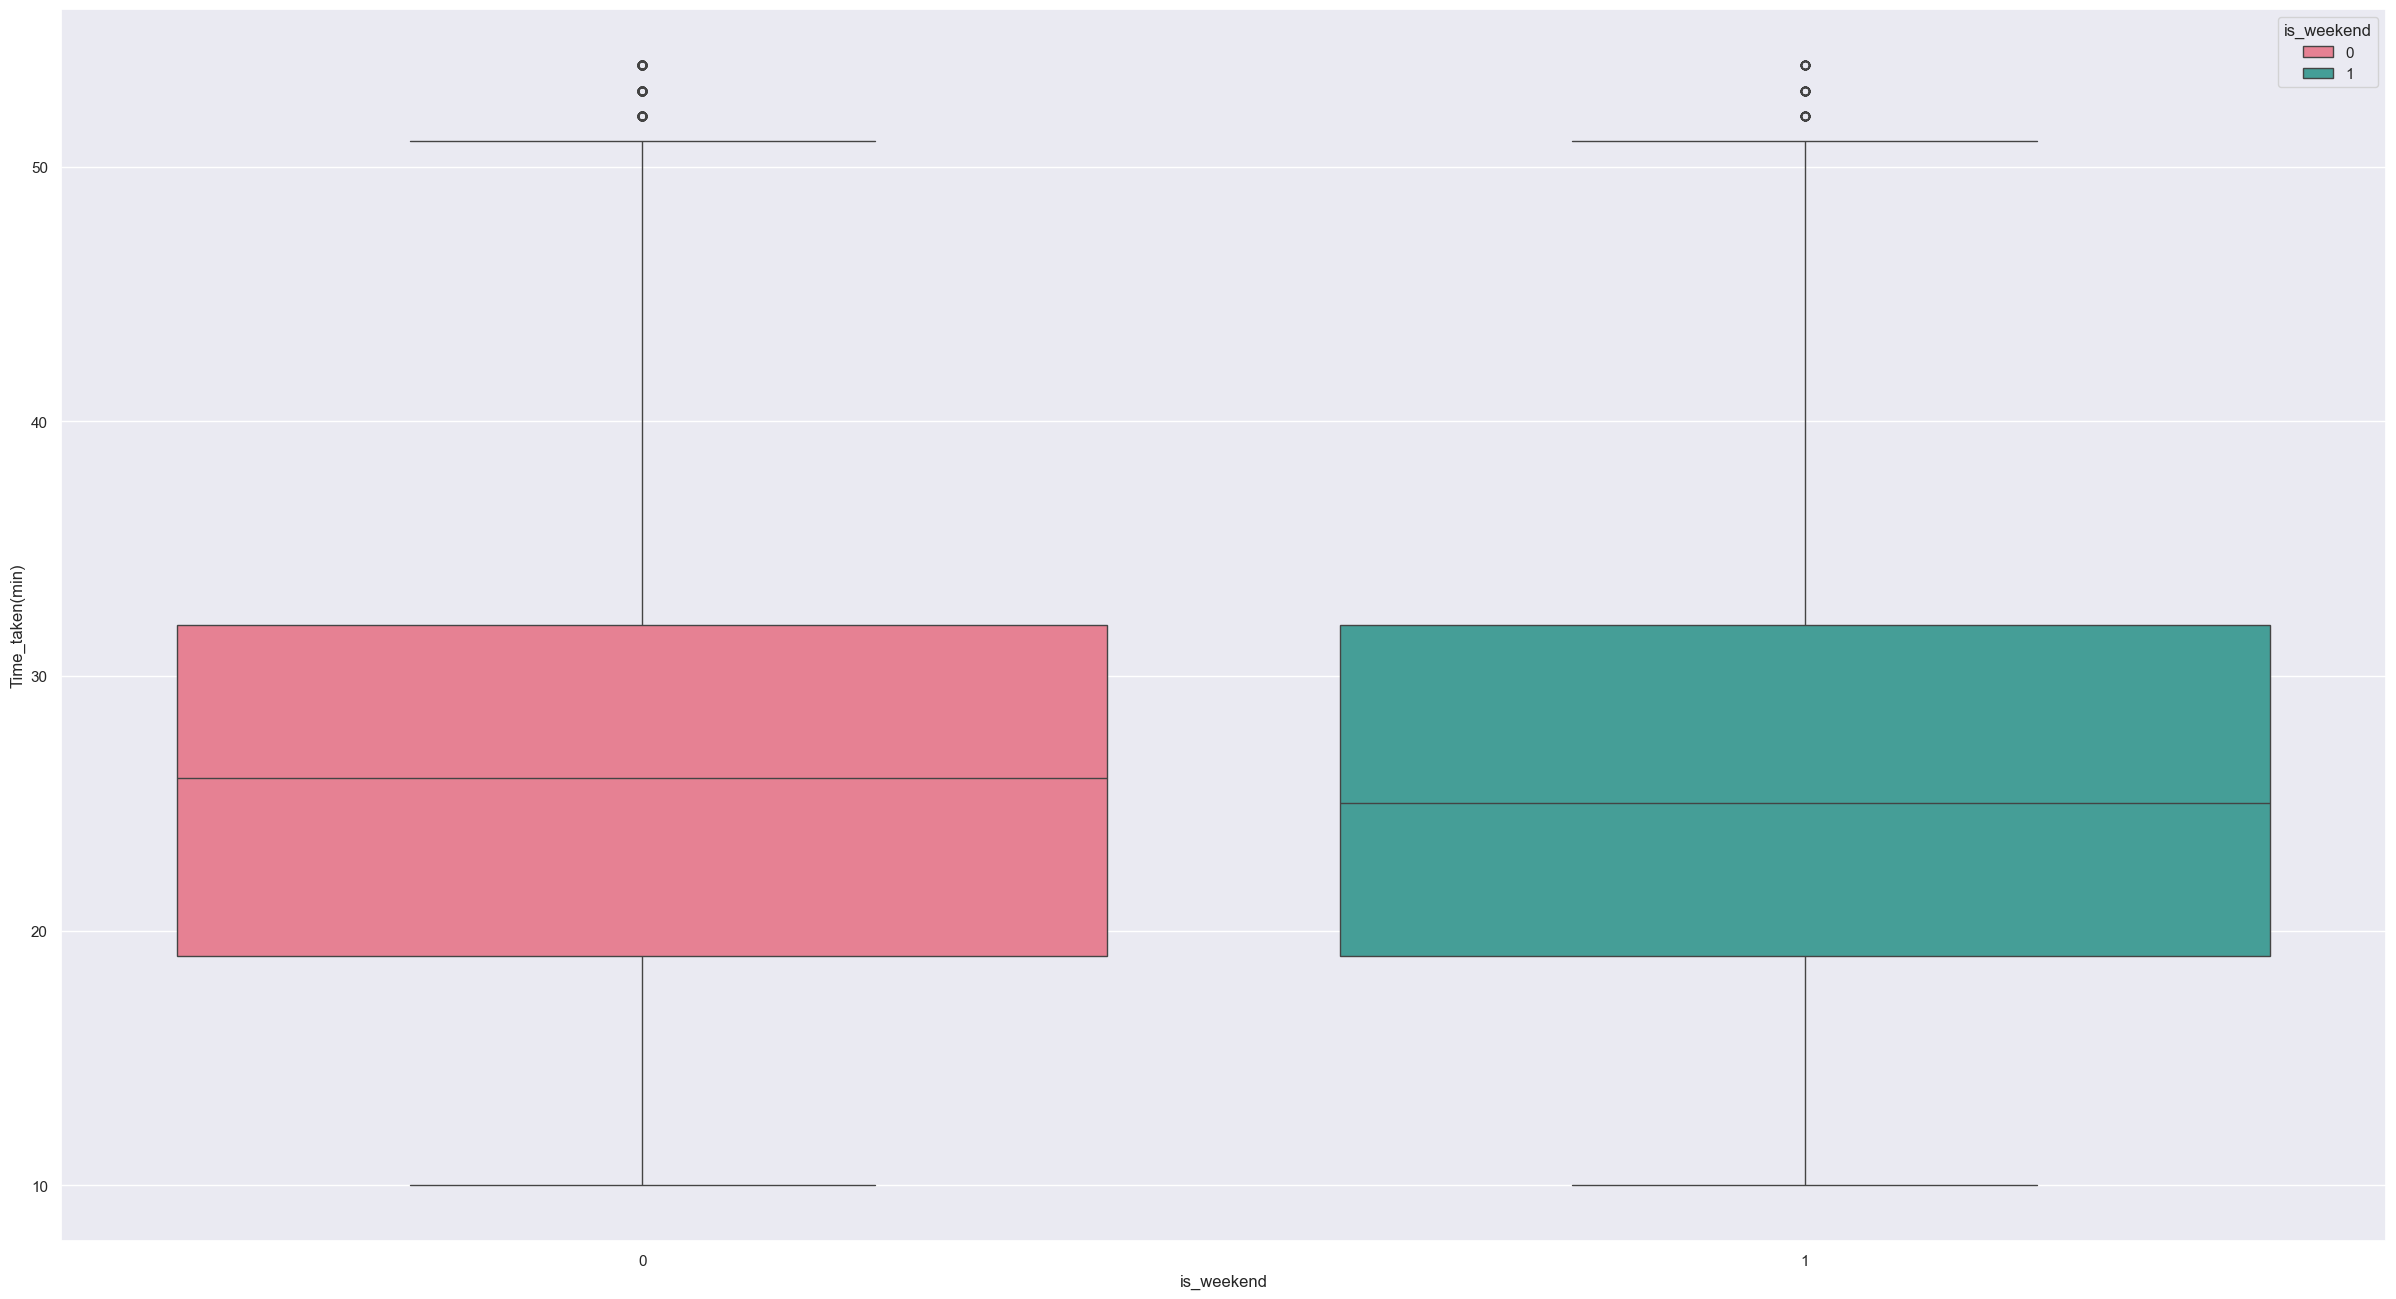

In [29]:
sns.boxplot(x = 'is_weekend' , y = 'Time_taken(min)' , data = df4, palette = 'husl', hue = 'is_weekend')

#### Hipótese 4: Pedidos no começo do mês possuem maior tempo de entrega
FALSA: o tempo é menor



<Axes: xlabel='is_month_start', ylabel='Time_taken(min)'>

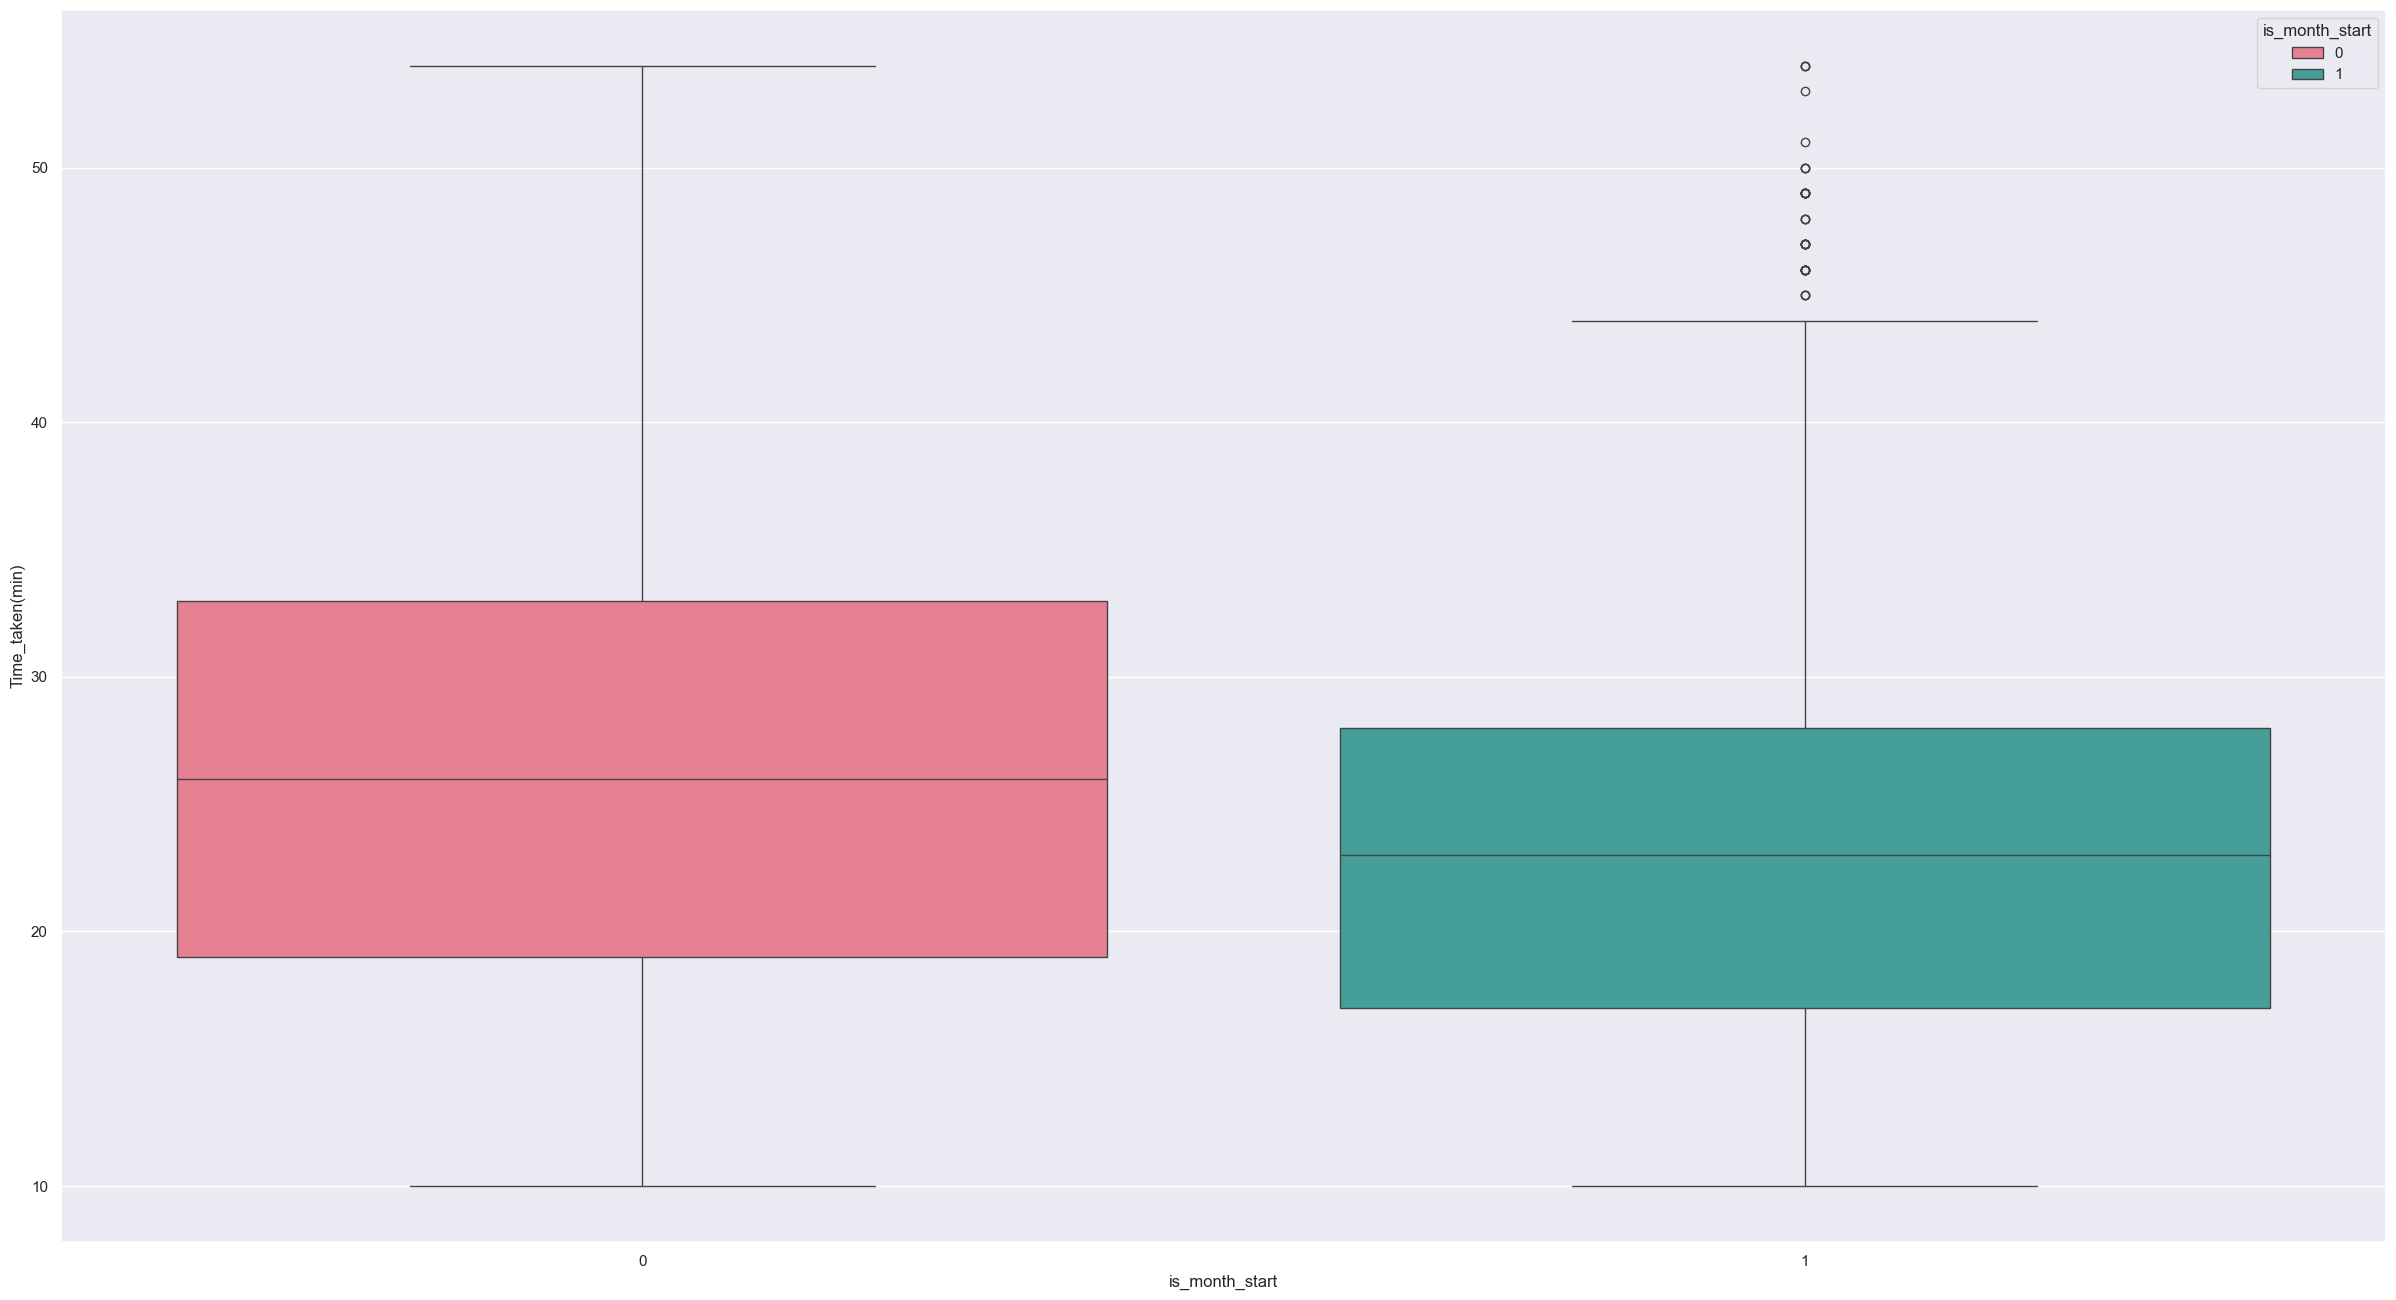

In [30]:
sns.boxplot(x = 'is_month_start' , y = 'Time_taken(min)' , data = df4, palette = 'husl', hue = 'is_month_start')

#### Hipótese 5: Tipos específicos de pedidos podem exigir diferentes tempos de entrega
FALSA. Há pouca diferença do tempo de entrega entre os tipos de pedido

<Axes: xlabel='Type_of_order', ylabel='Time_taken(min)'>

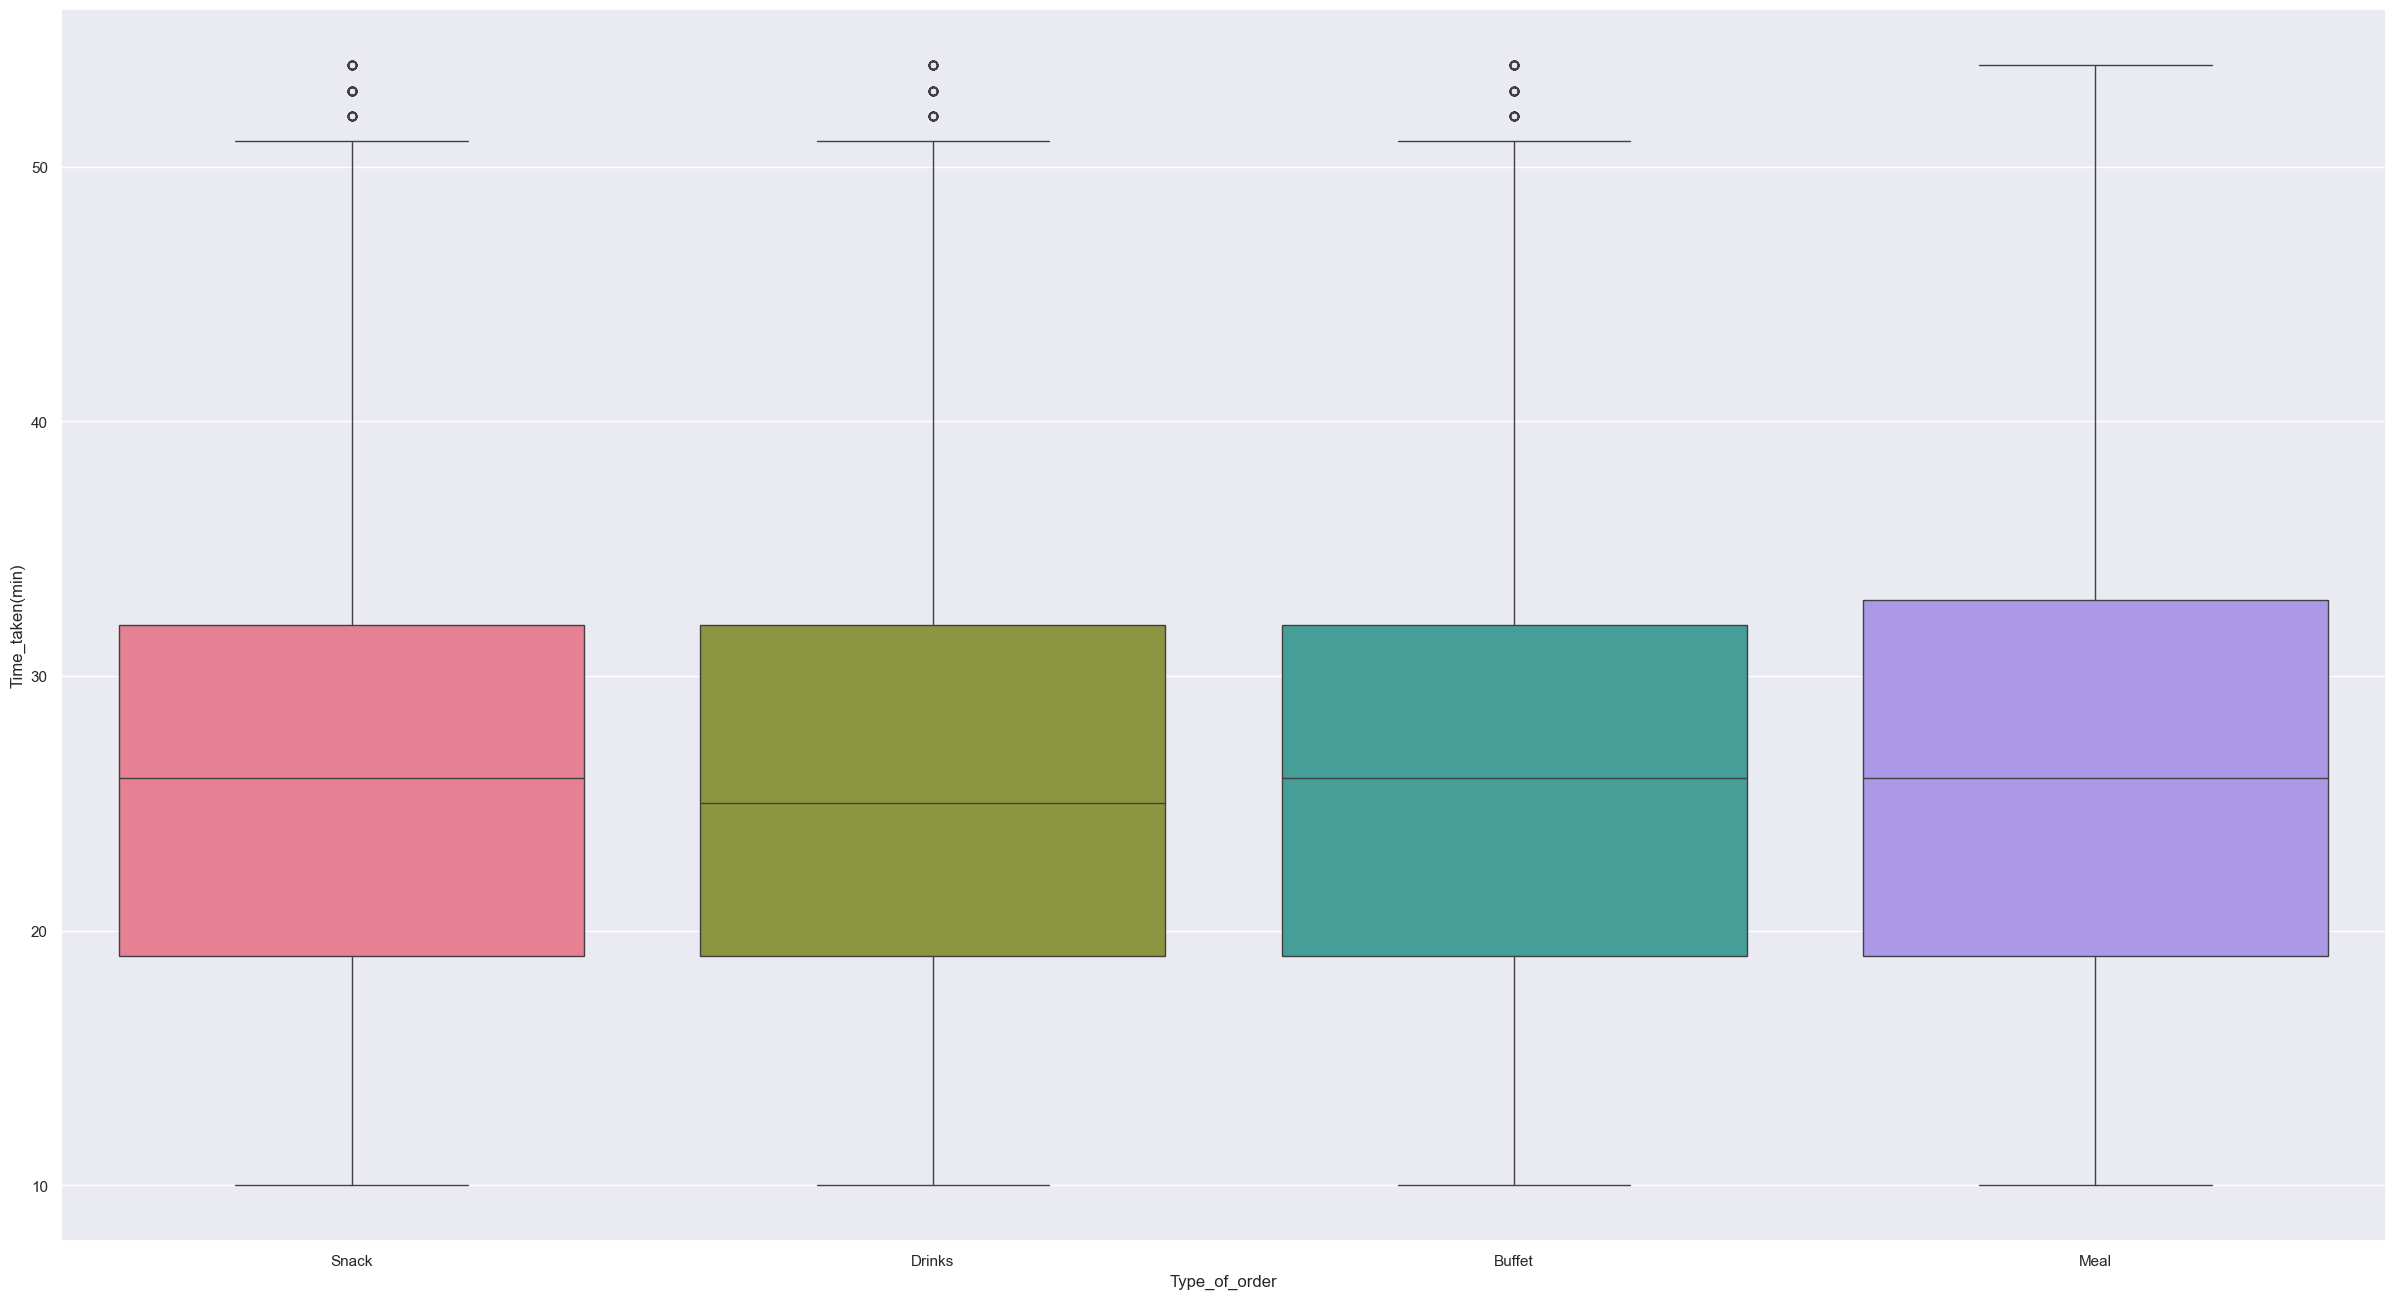

In [31]:
sns.boxplot(x = 'Type_of_order', y = 'Time_taken(min)', data = df4, palette = 'husl', hue = 'Type_of_order')

#### Hipótese 6: A idade do entregador afeta a velocidade da entrega
FALSA. Não há relação entre a idade e o tempo de entrega

<Axes: >

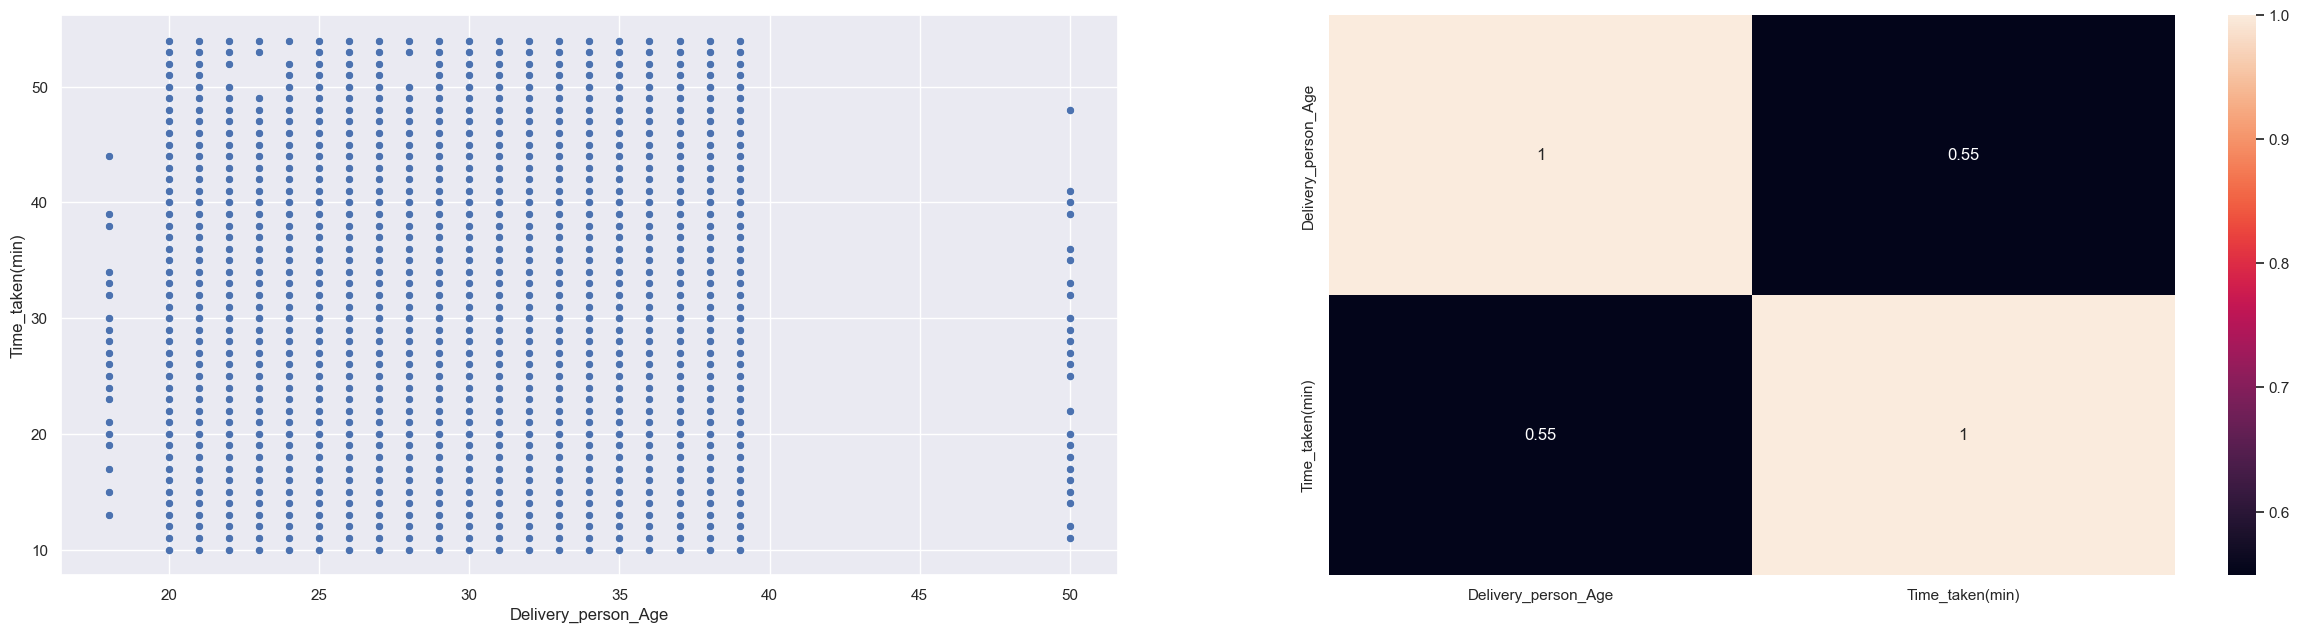

In [32]:
aux6 = df4[['Delivery_person_Age', 'Time_taken(min)']].groupby('Delivery_person_Age').mean().reset_index()

grid = GridSpec(2,2)

plt.subplot(grid[0,0])
sns.scatterplot(x = 'Delivery_person_Age', y = 'Time_taken(min)', data = df4)

plt.subplot(grid[0,1])
sns.heatmap(aux6.corr(method = 'pearson'), annot = True)


#### Hipótese 7: Avaliações do entregador podem impactar a eficiência da entrega
VERDADEIRA. A média do tempo de entrega varia conforme o rating do entregador.

<Axes: xlabel='Delivery_person_Ratings', ylabel='Time_taken(min)'>

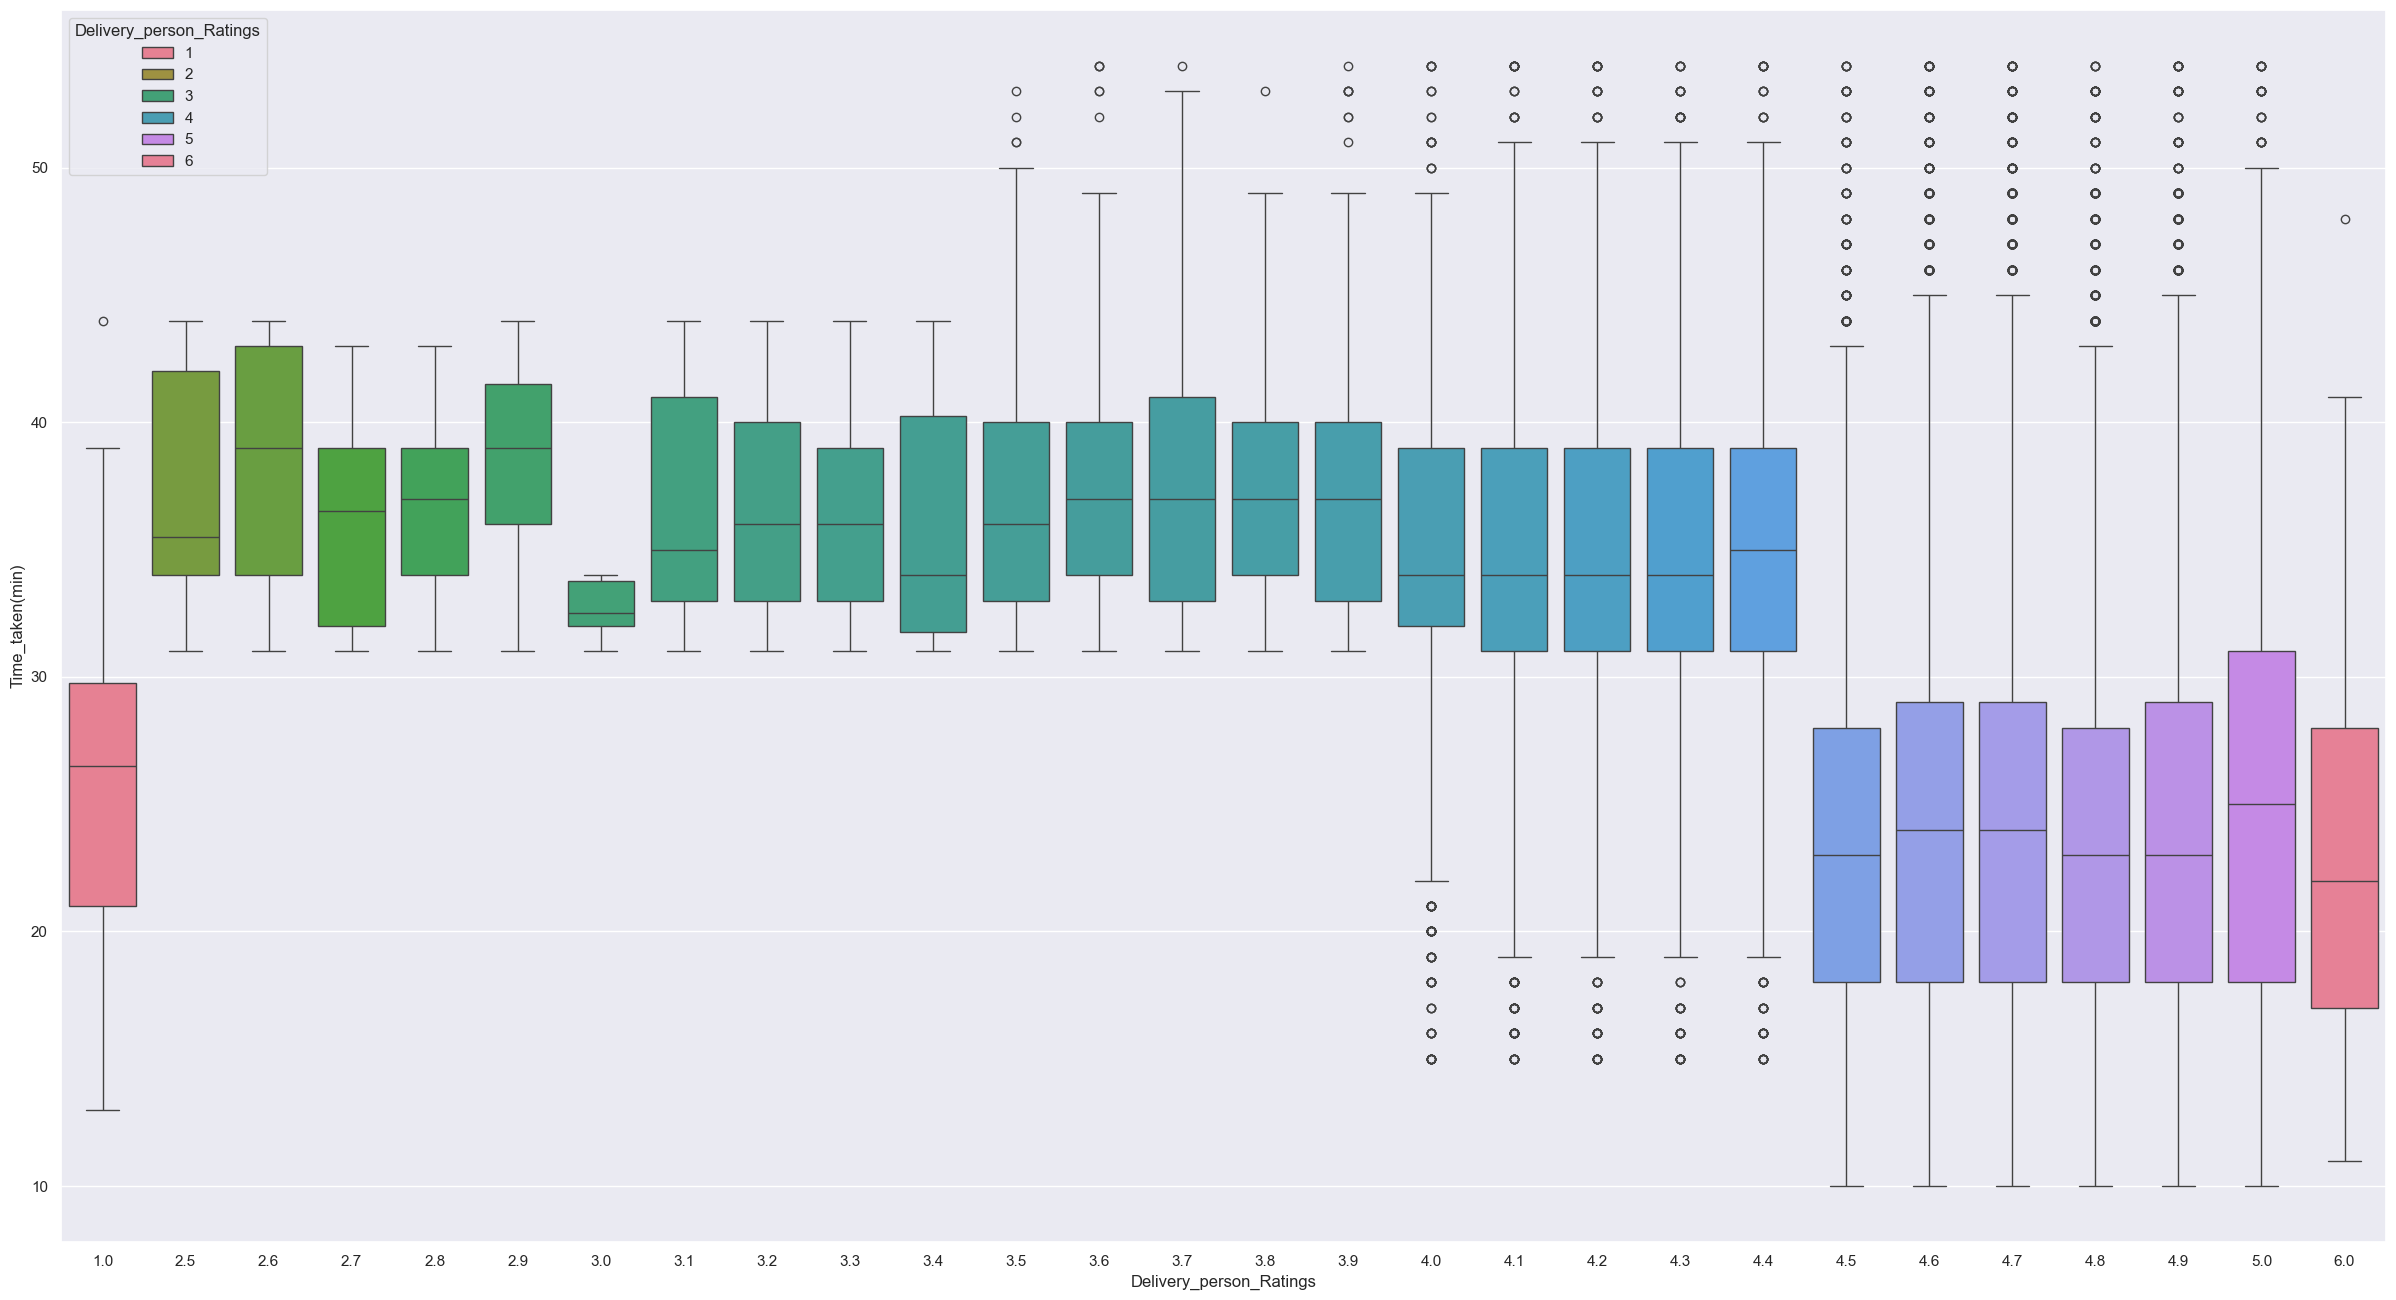

In [33]:
sns.boxplot(x='Delivery_person_Ratings', y='Time_taken(min)', data=df4, palette = 'husl', hue = 'Delivery_person_Ratings')

#### Hipótese 8: O tipo de veículo usado para a entrega pode impactar no tempo de entrega;
VERDADEIRA


<Axes: xlabel='Type_of_vehicle', ylabel='Time_taken(min)'>

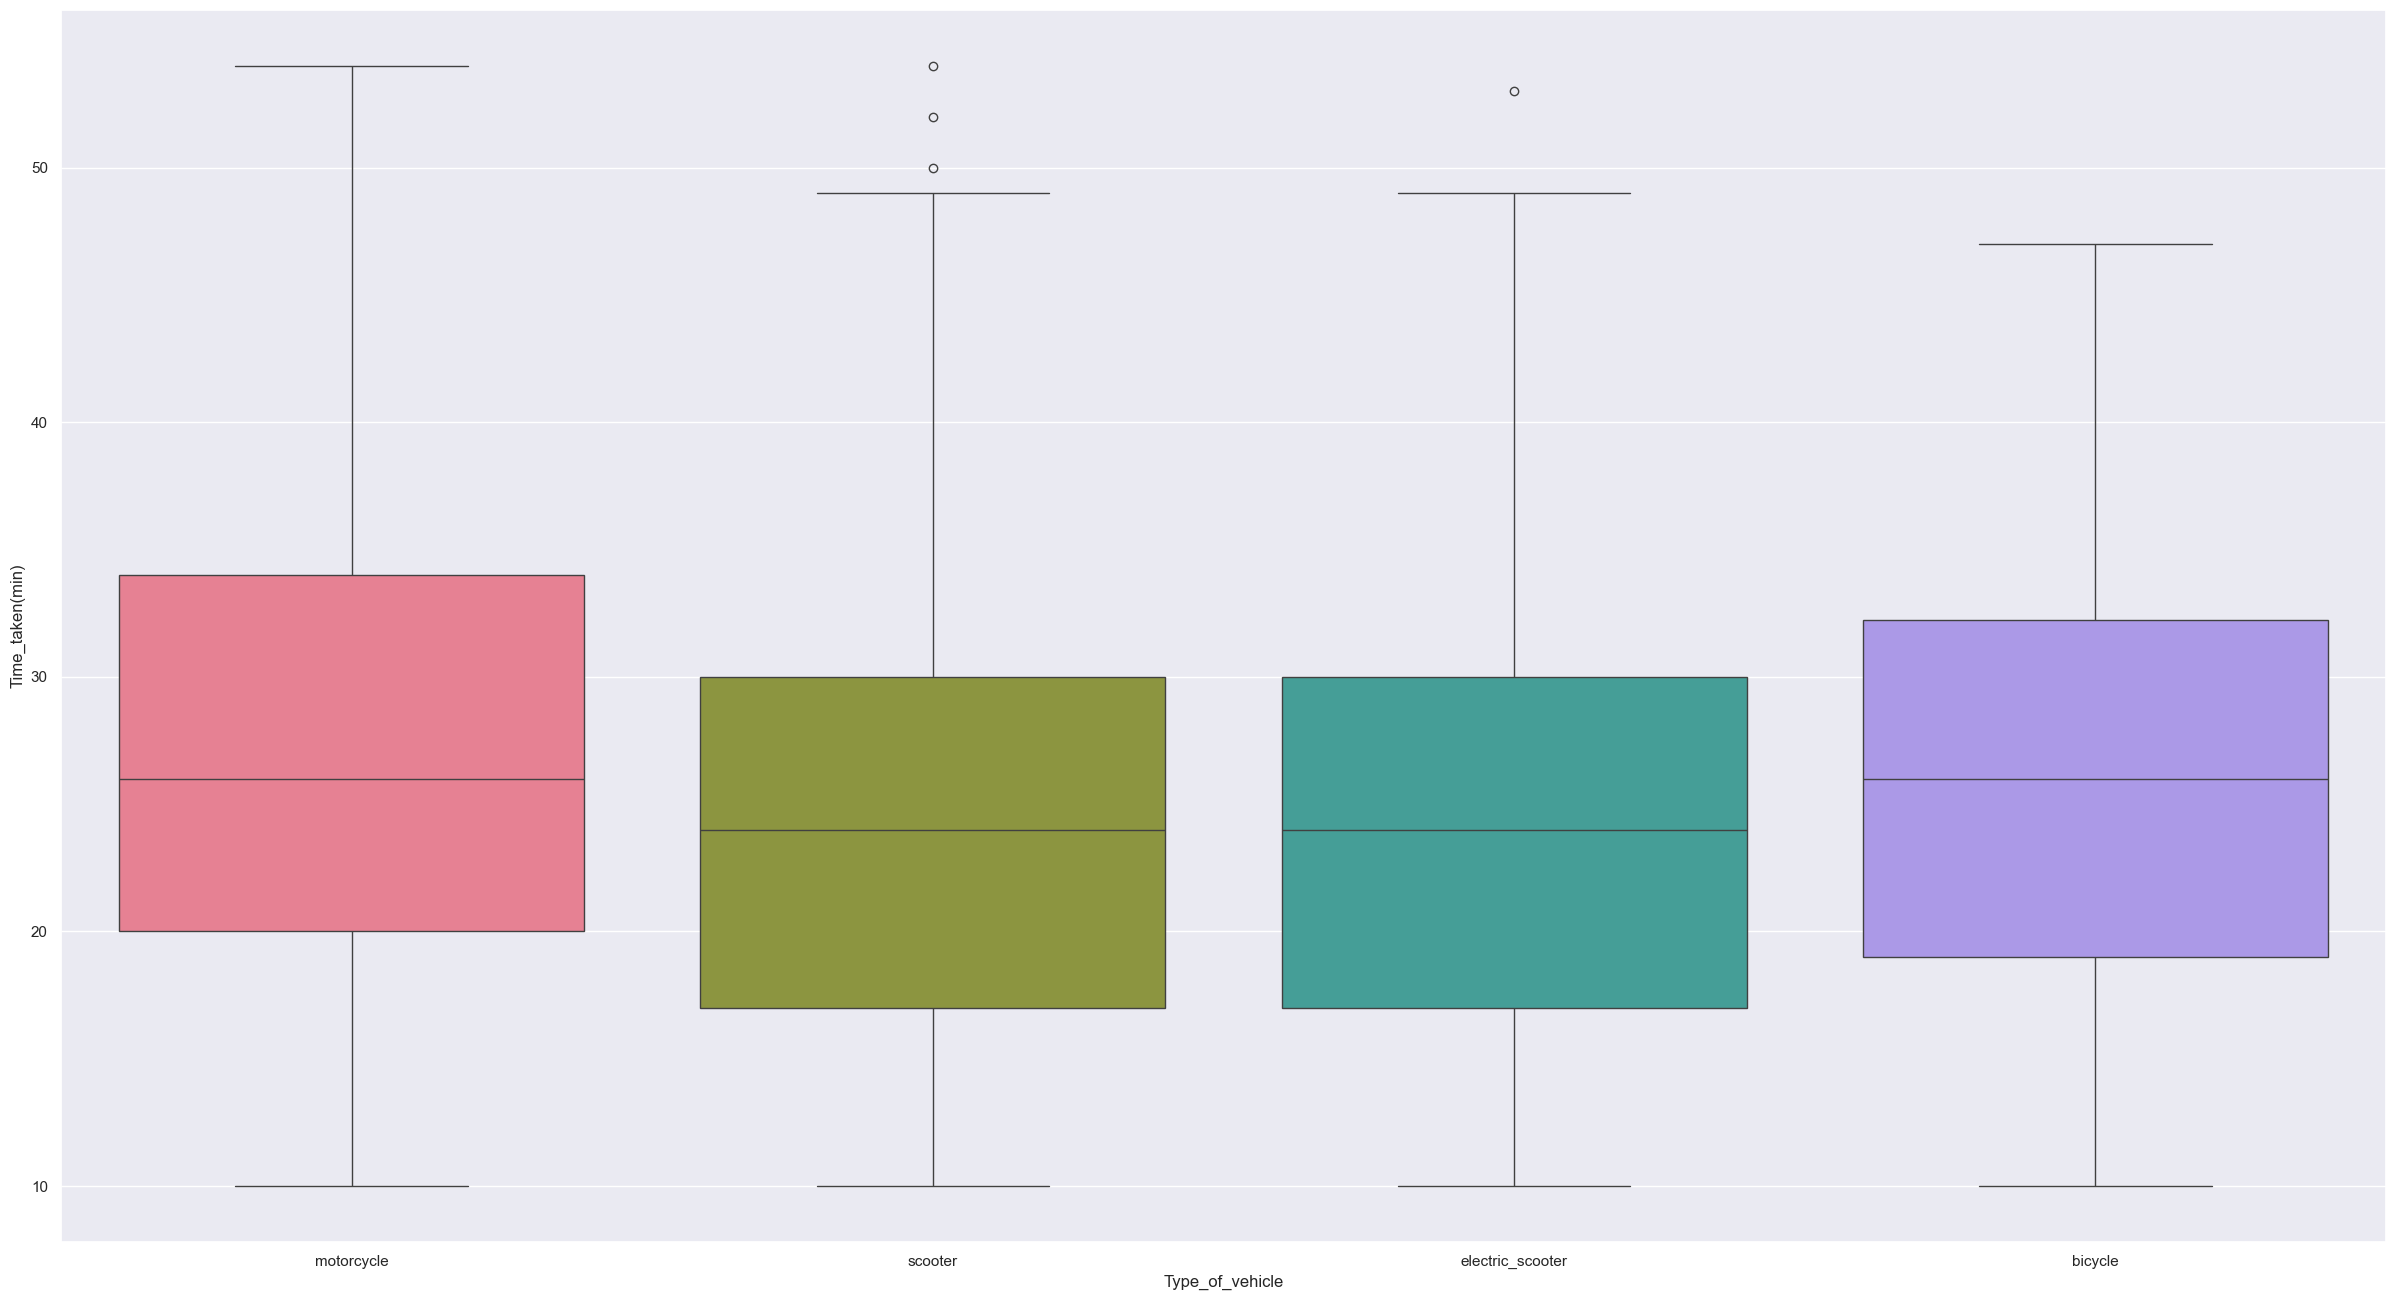

In [34]:
sns.boxplot(x='Type_of_vehicle', y='Time_taken(min)', data=df4, palette = 'husl', hue = 'Type_of_vehicle')

#### Hipótese 9: Múltiplas entregas em uma única rota podem aumentar o tempo de entrega
VERDADEIRA

<Axes: xlabel='multiple_deliveries', ylabel='Time_taken(min)'>

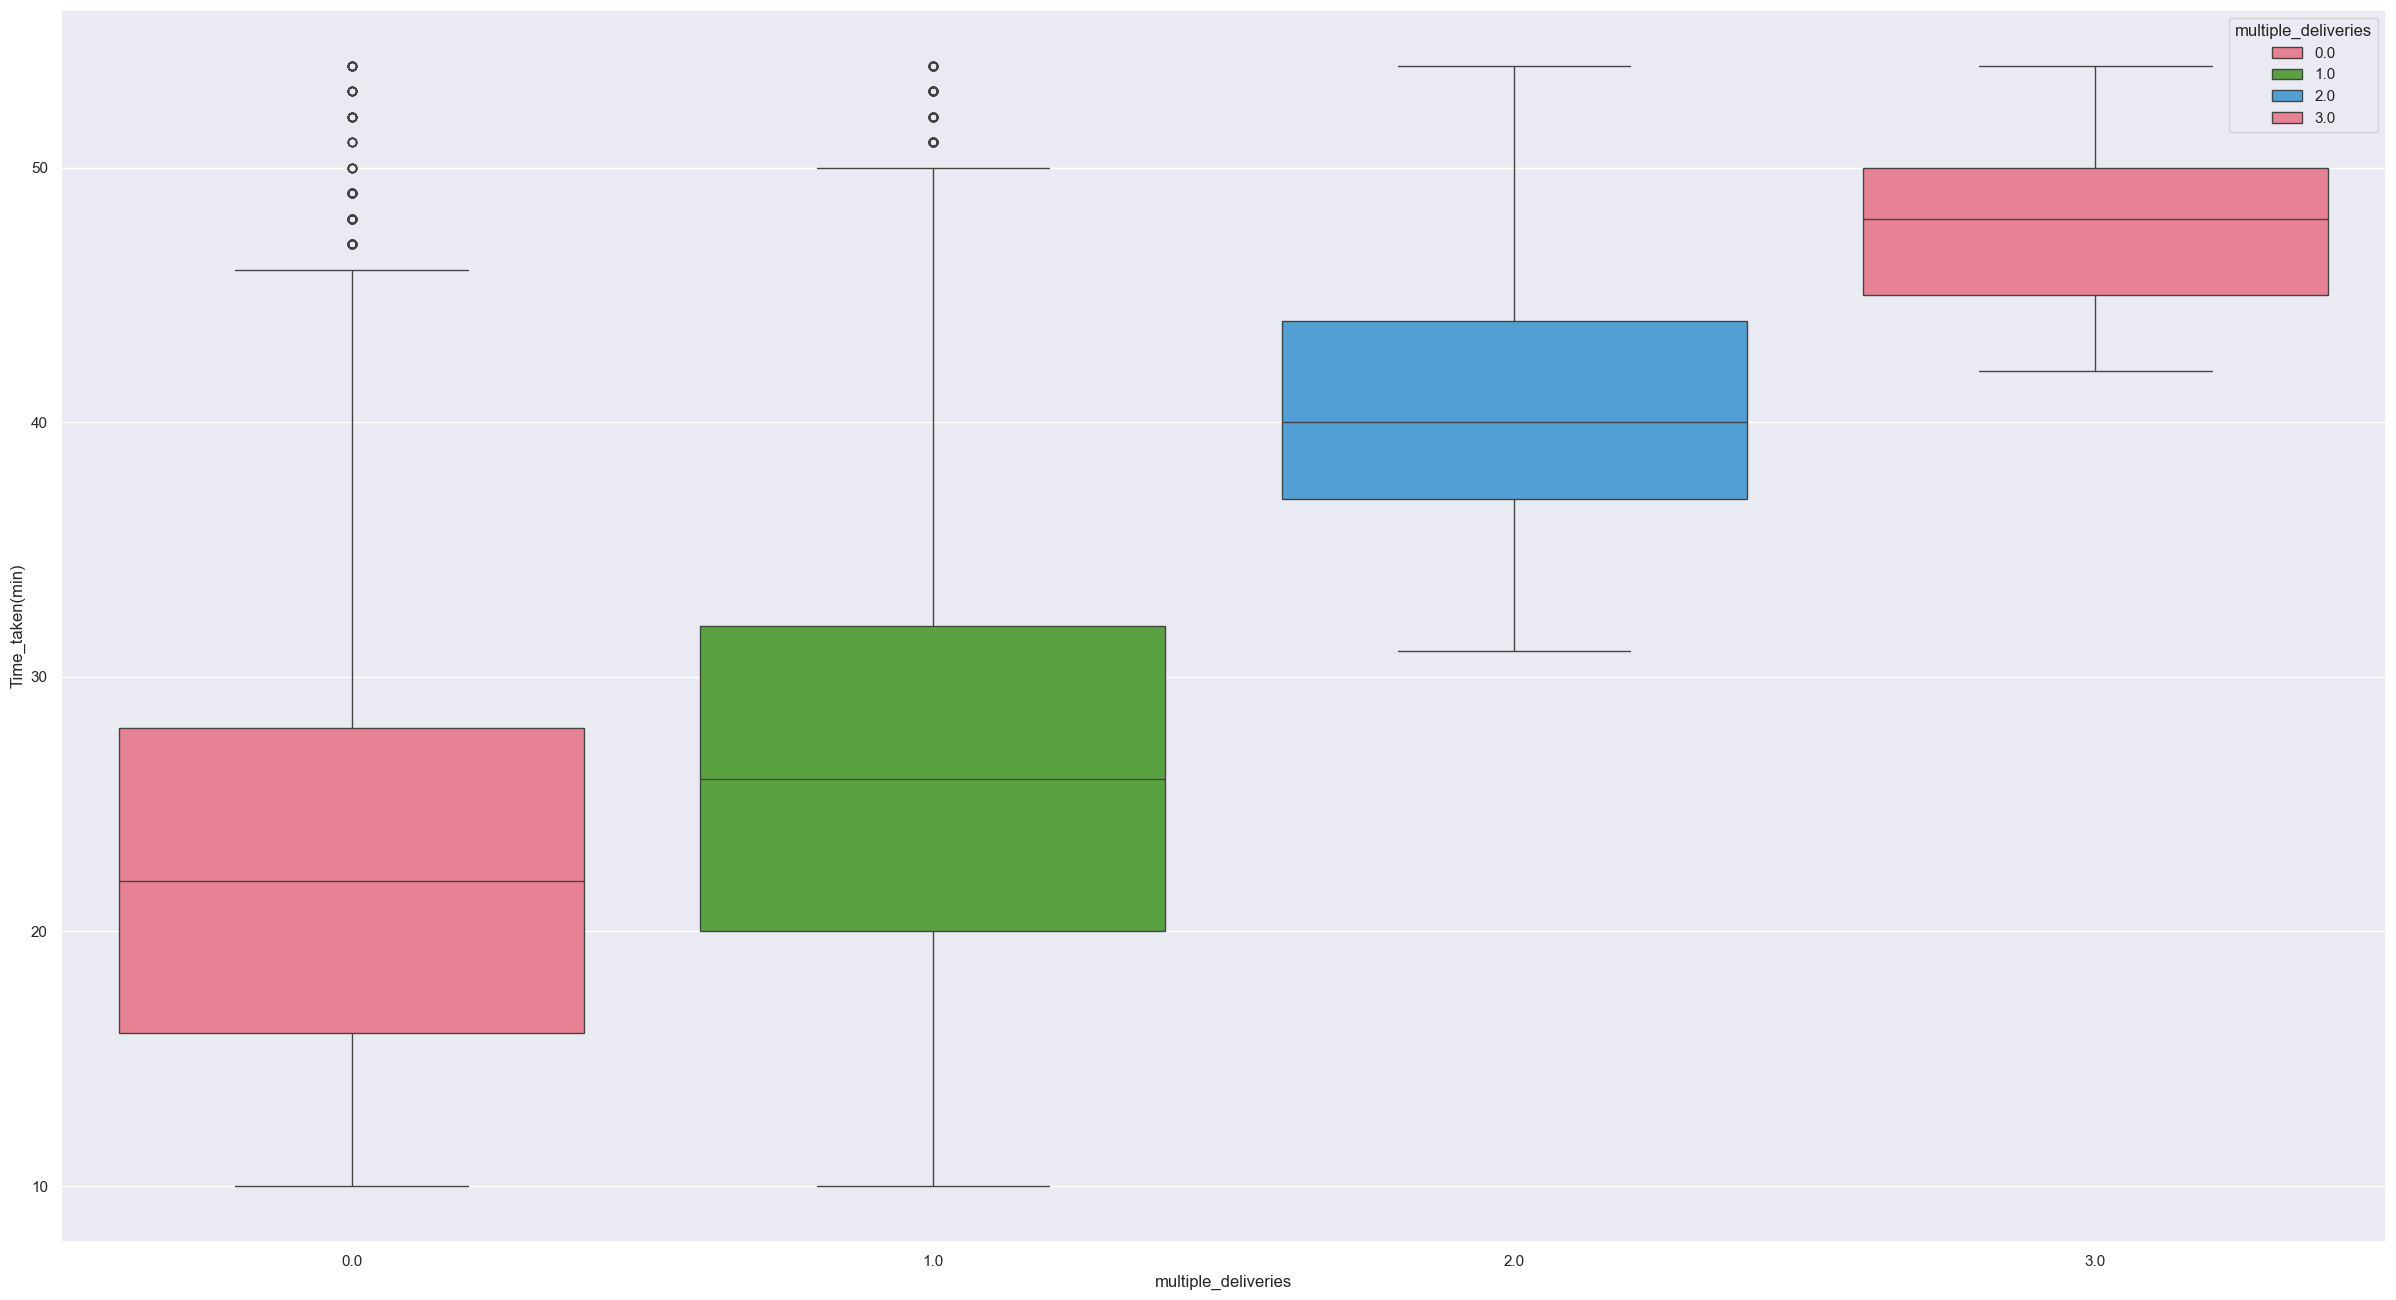

In [35]:
sns.boxplot(x='multiple_deliveries', y='Time_taken(min)', data=df4, palette = 'husl', hue = 'multiple_deliveries')

#### Hipótese 10: A condição do veículo pode influenciar o tempo de entrega
VERDADEIRA

<Axes: xlabel='Vehicle_condition', ylabel='Time_taken(min)'>

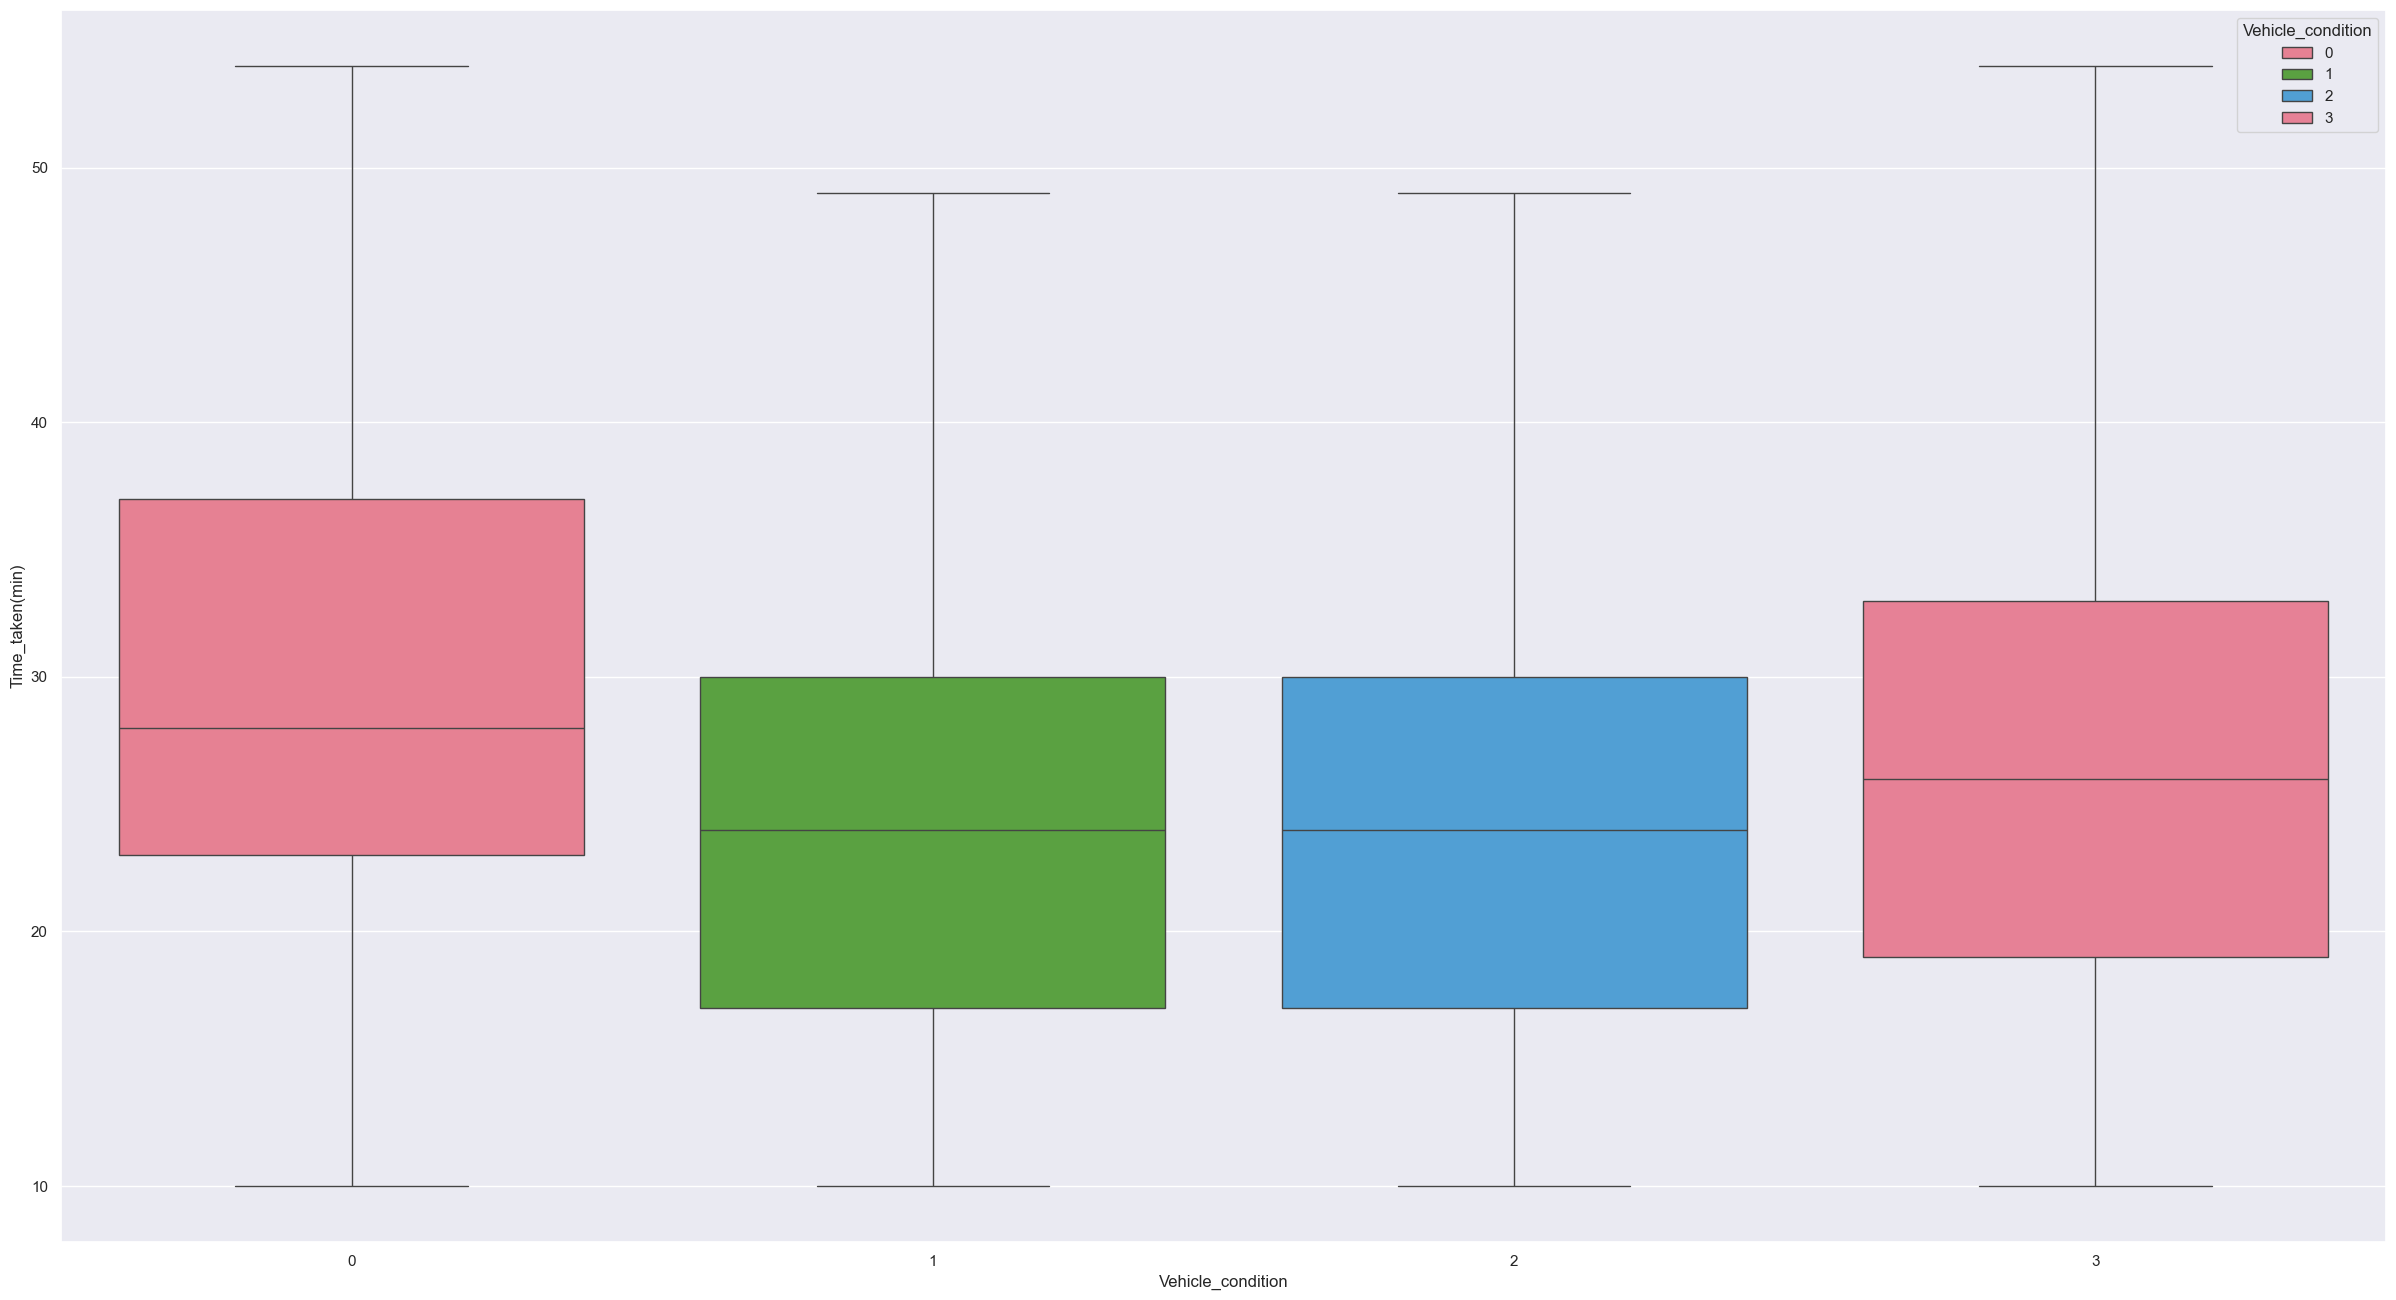

In [36]:
sns.boxplot(x='Vehicle_condition', y='Time_taken(min)', data=df4, palette = 'husl', hue = 'Vehicle_condition')

#### Hipótese 11: Condições climáticas adversas podem aumentar o tempo de entrega
VERDADEIRA

<Axes: xlabel='Weatherconditions', ylabel='Time_taken(min)'>

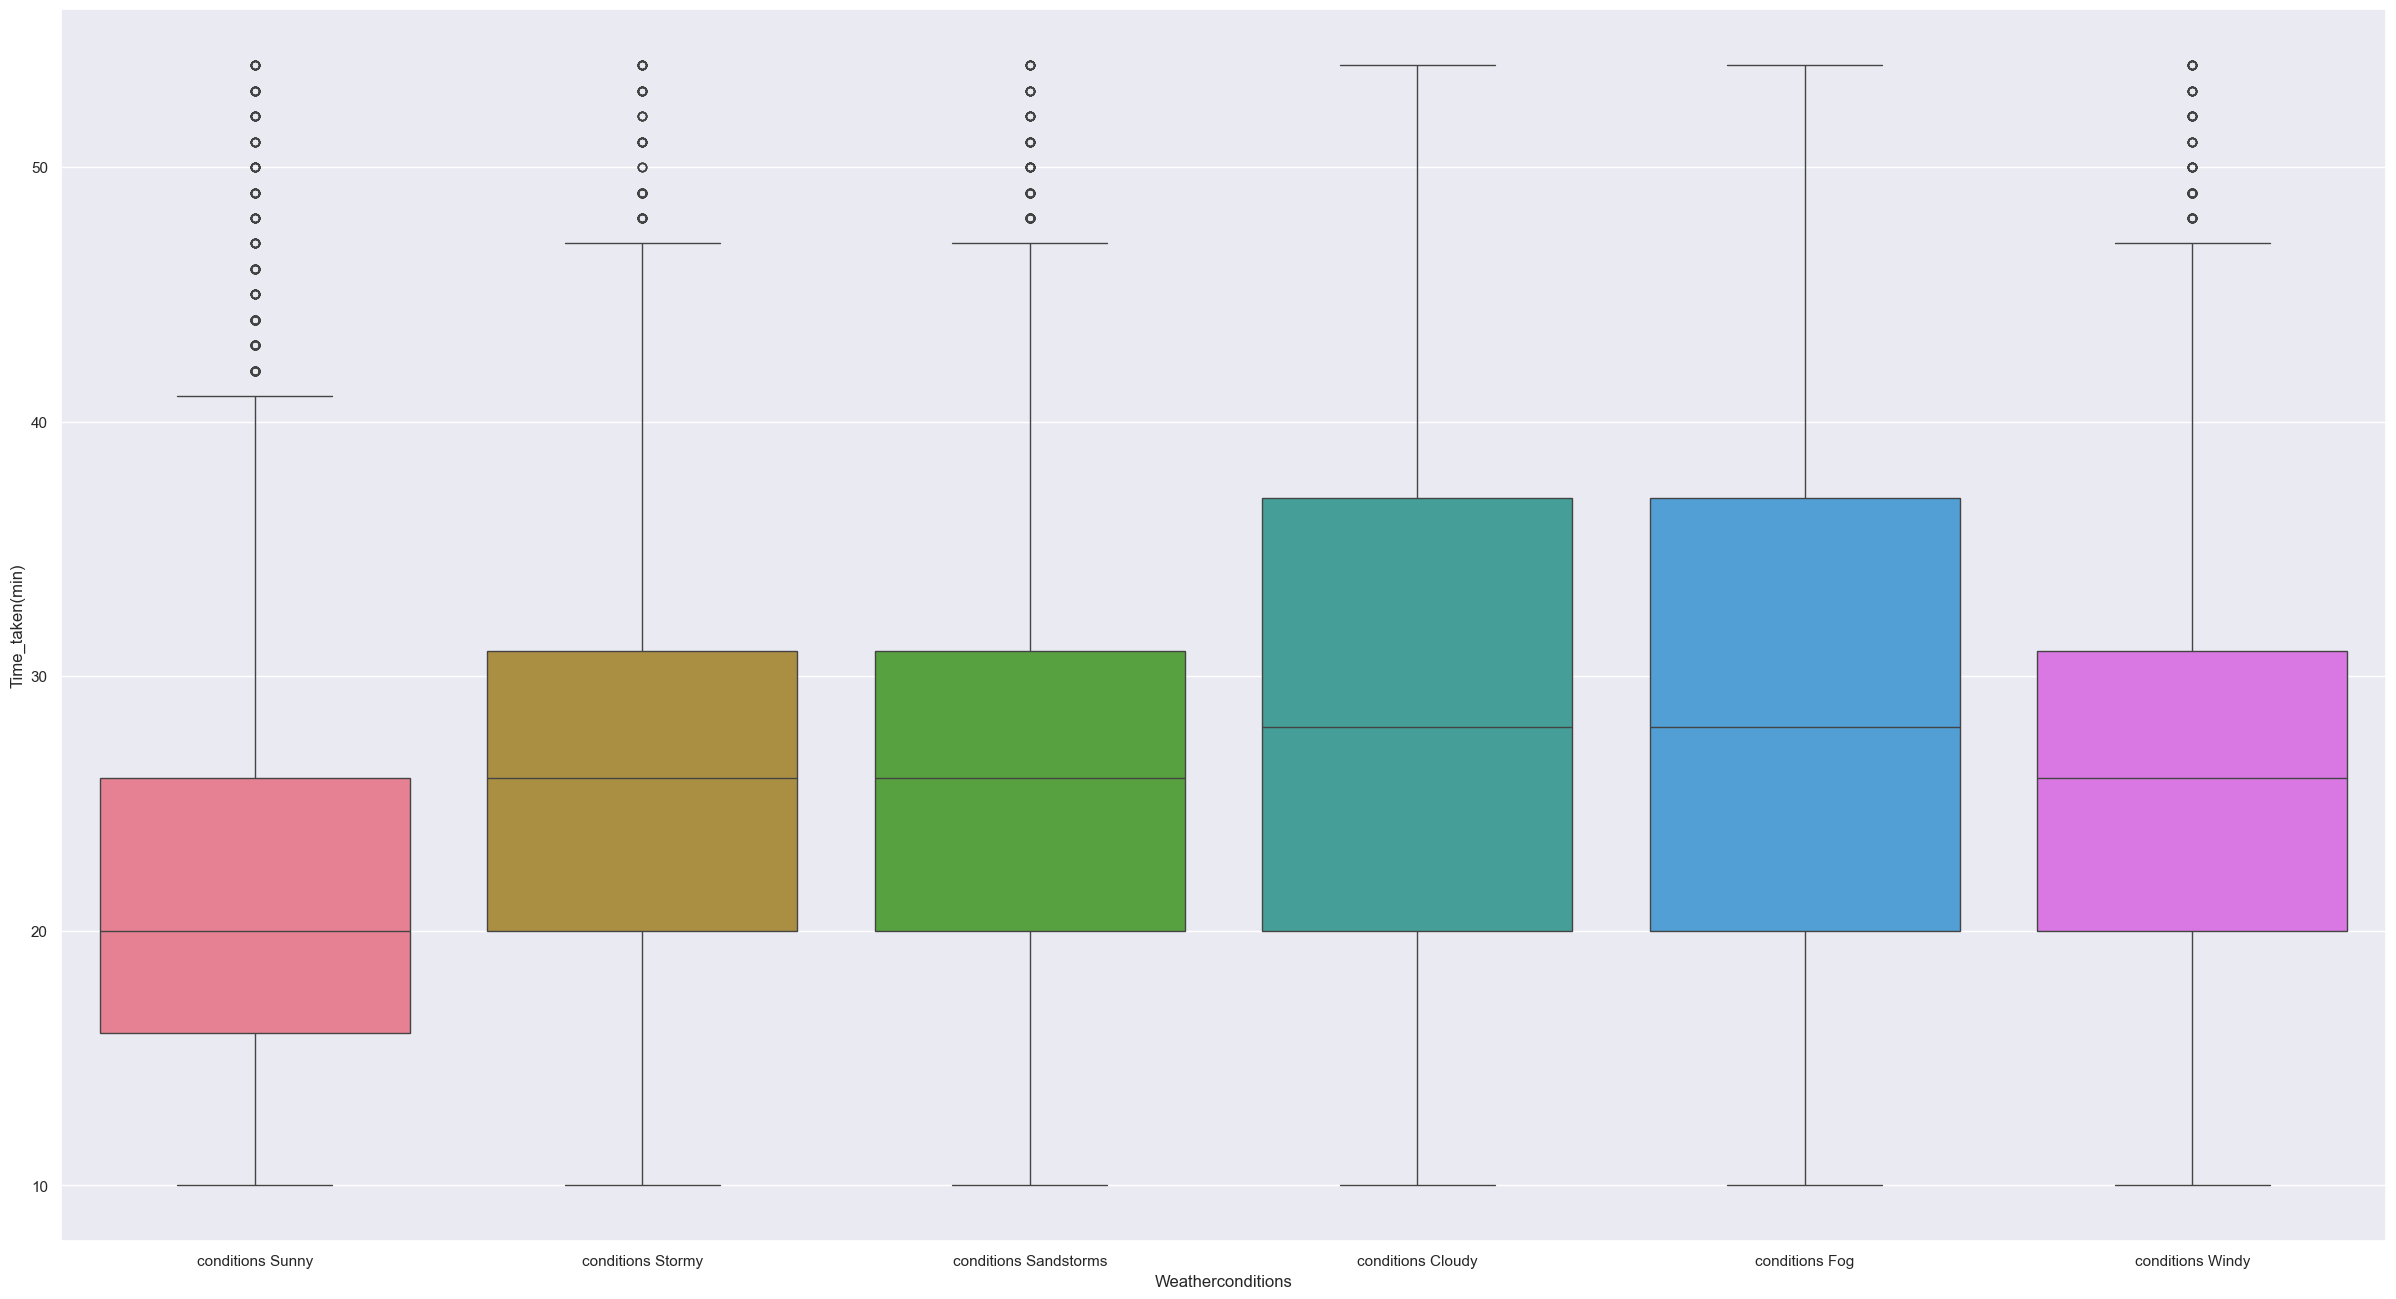

In [37]:
sns.boxplot(x='Weatherconditions', y='Time_taken(min)', data=df4, palette = 'husl', hue = 'Weatherconditions')

#### Hipótese 12: A densidade do tráfego pode impactar o tempo de entrega
VERDADEIRA

<Axes: xlabel='Road_traffic_density', ylabel='Time_taken(min)'>

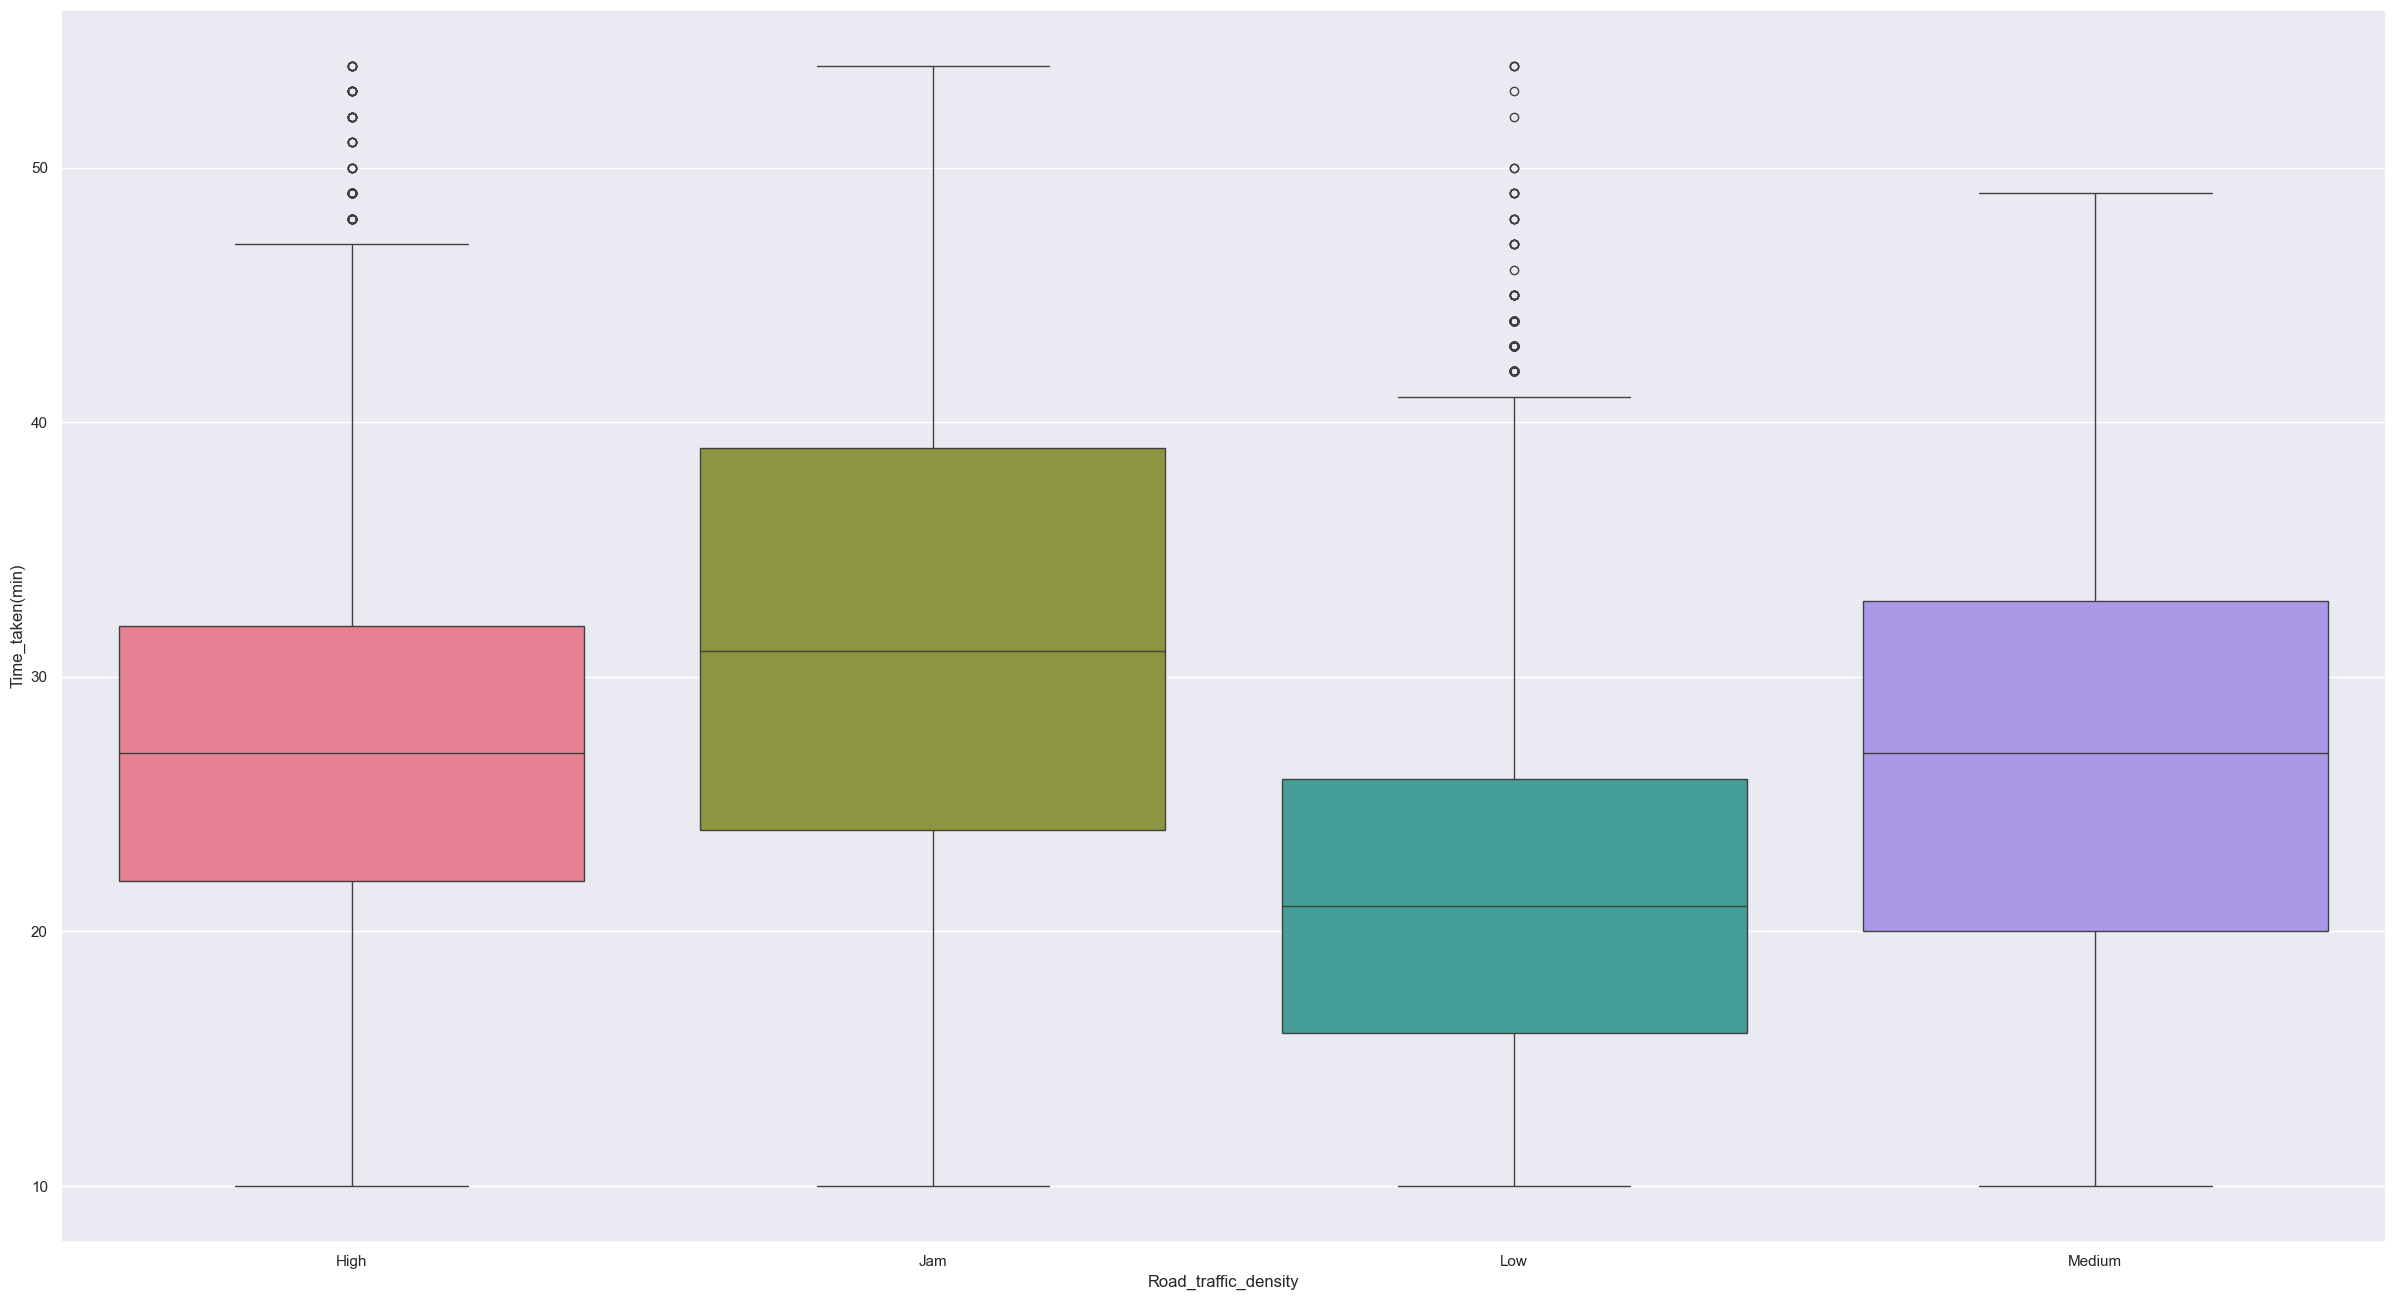

In [38]:
sns.boxplot(x='Road_traffic_density', y='Time_taken(min)', data=df4, palette = 'husl', hue = 'Road_traffic_density')

#### Hipótese 13: Festivais ou eventos na cidade podem afetar o tempo de entrega
VERDADEIRA

<Axes: xlabel='Festival', ylabel='Time_taken(min)'>

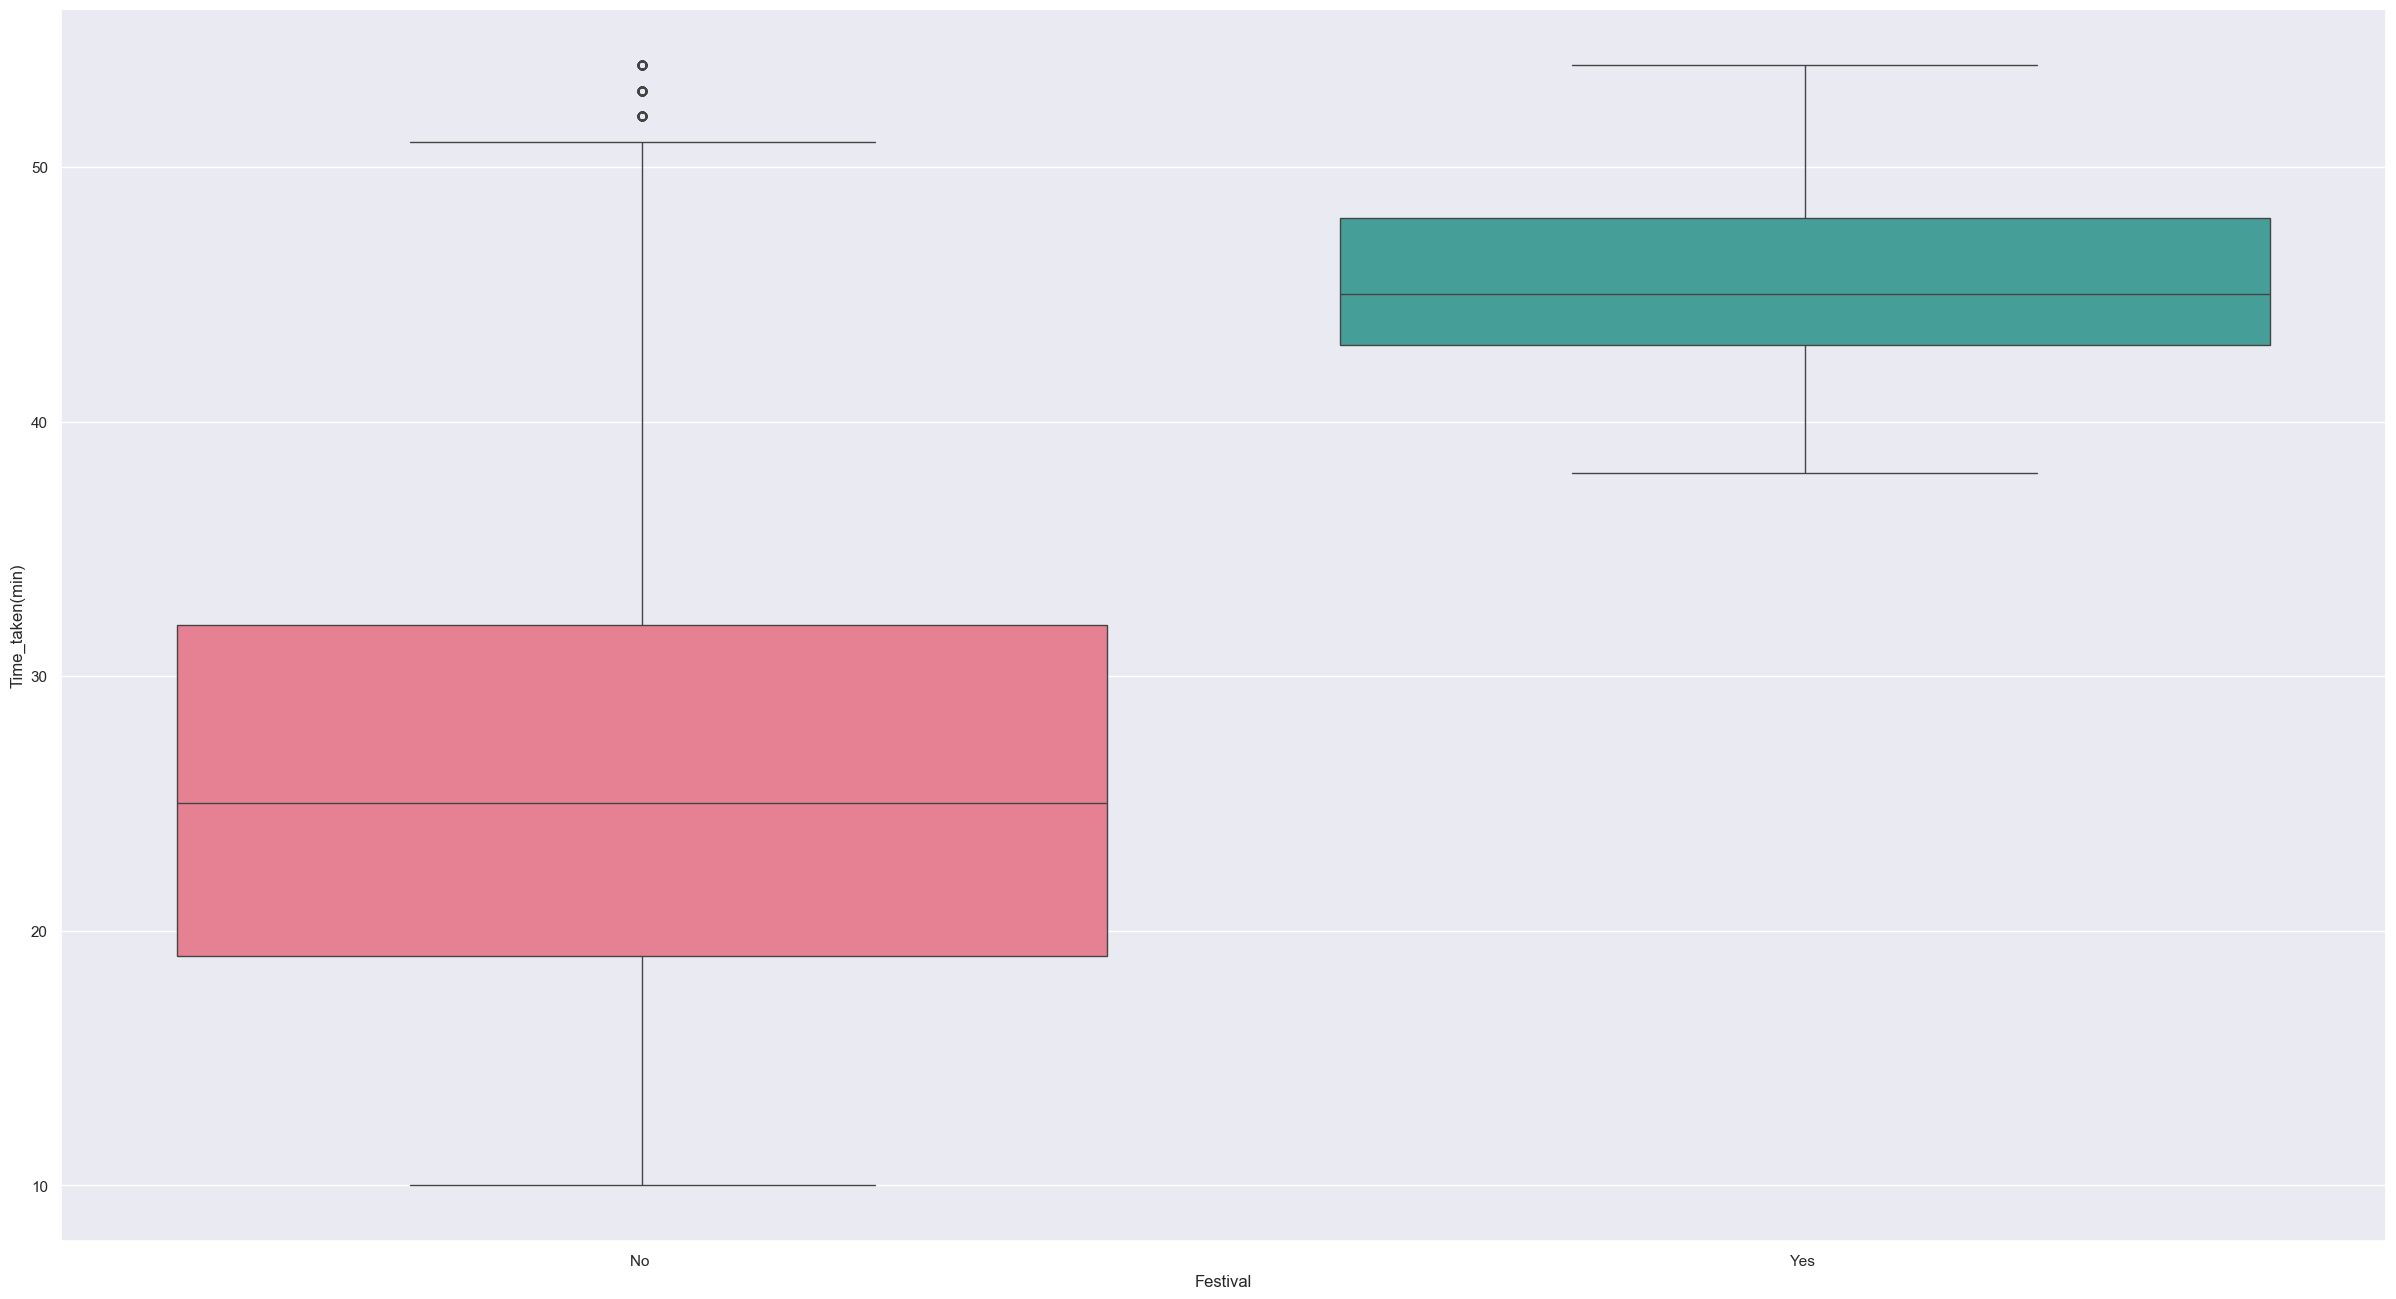

In [39]:
sns.boxplot(x='Festival', y='Time_taken(min)', data=df4, palette = 'husl', hue = 'Festival')

### 4.3 Análise Multivariada

In [40]:
num_attributes2 = df4.select_dtypes(include = ['int64', 'float64', 'int32'])
num_attributes2.drop(columns = ['year', 'is_year_start', 'is_year_end'], inplace = True)

<Axes: >

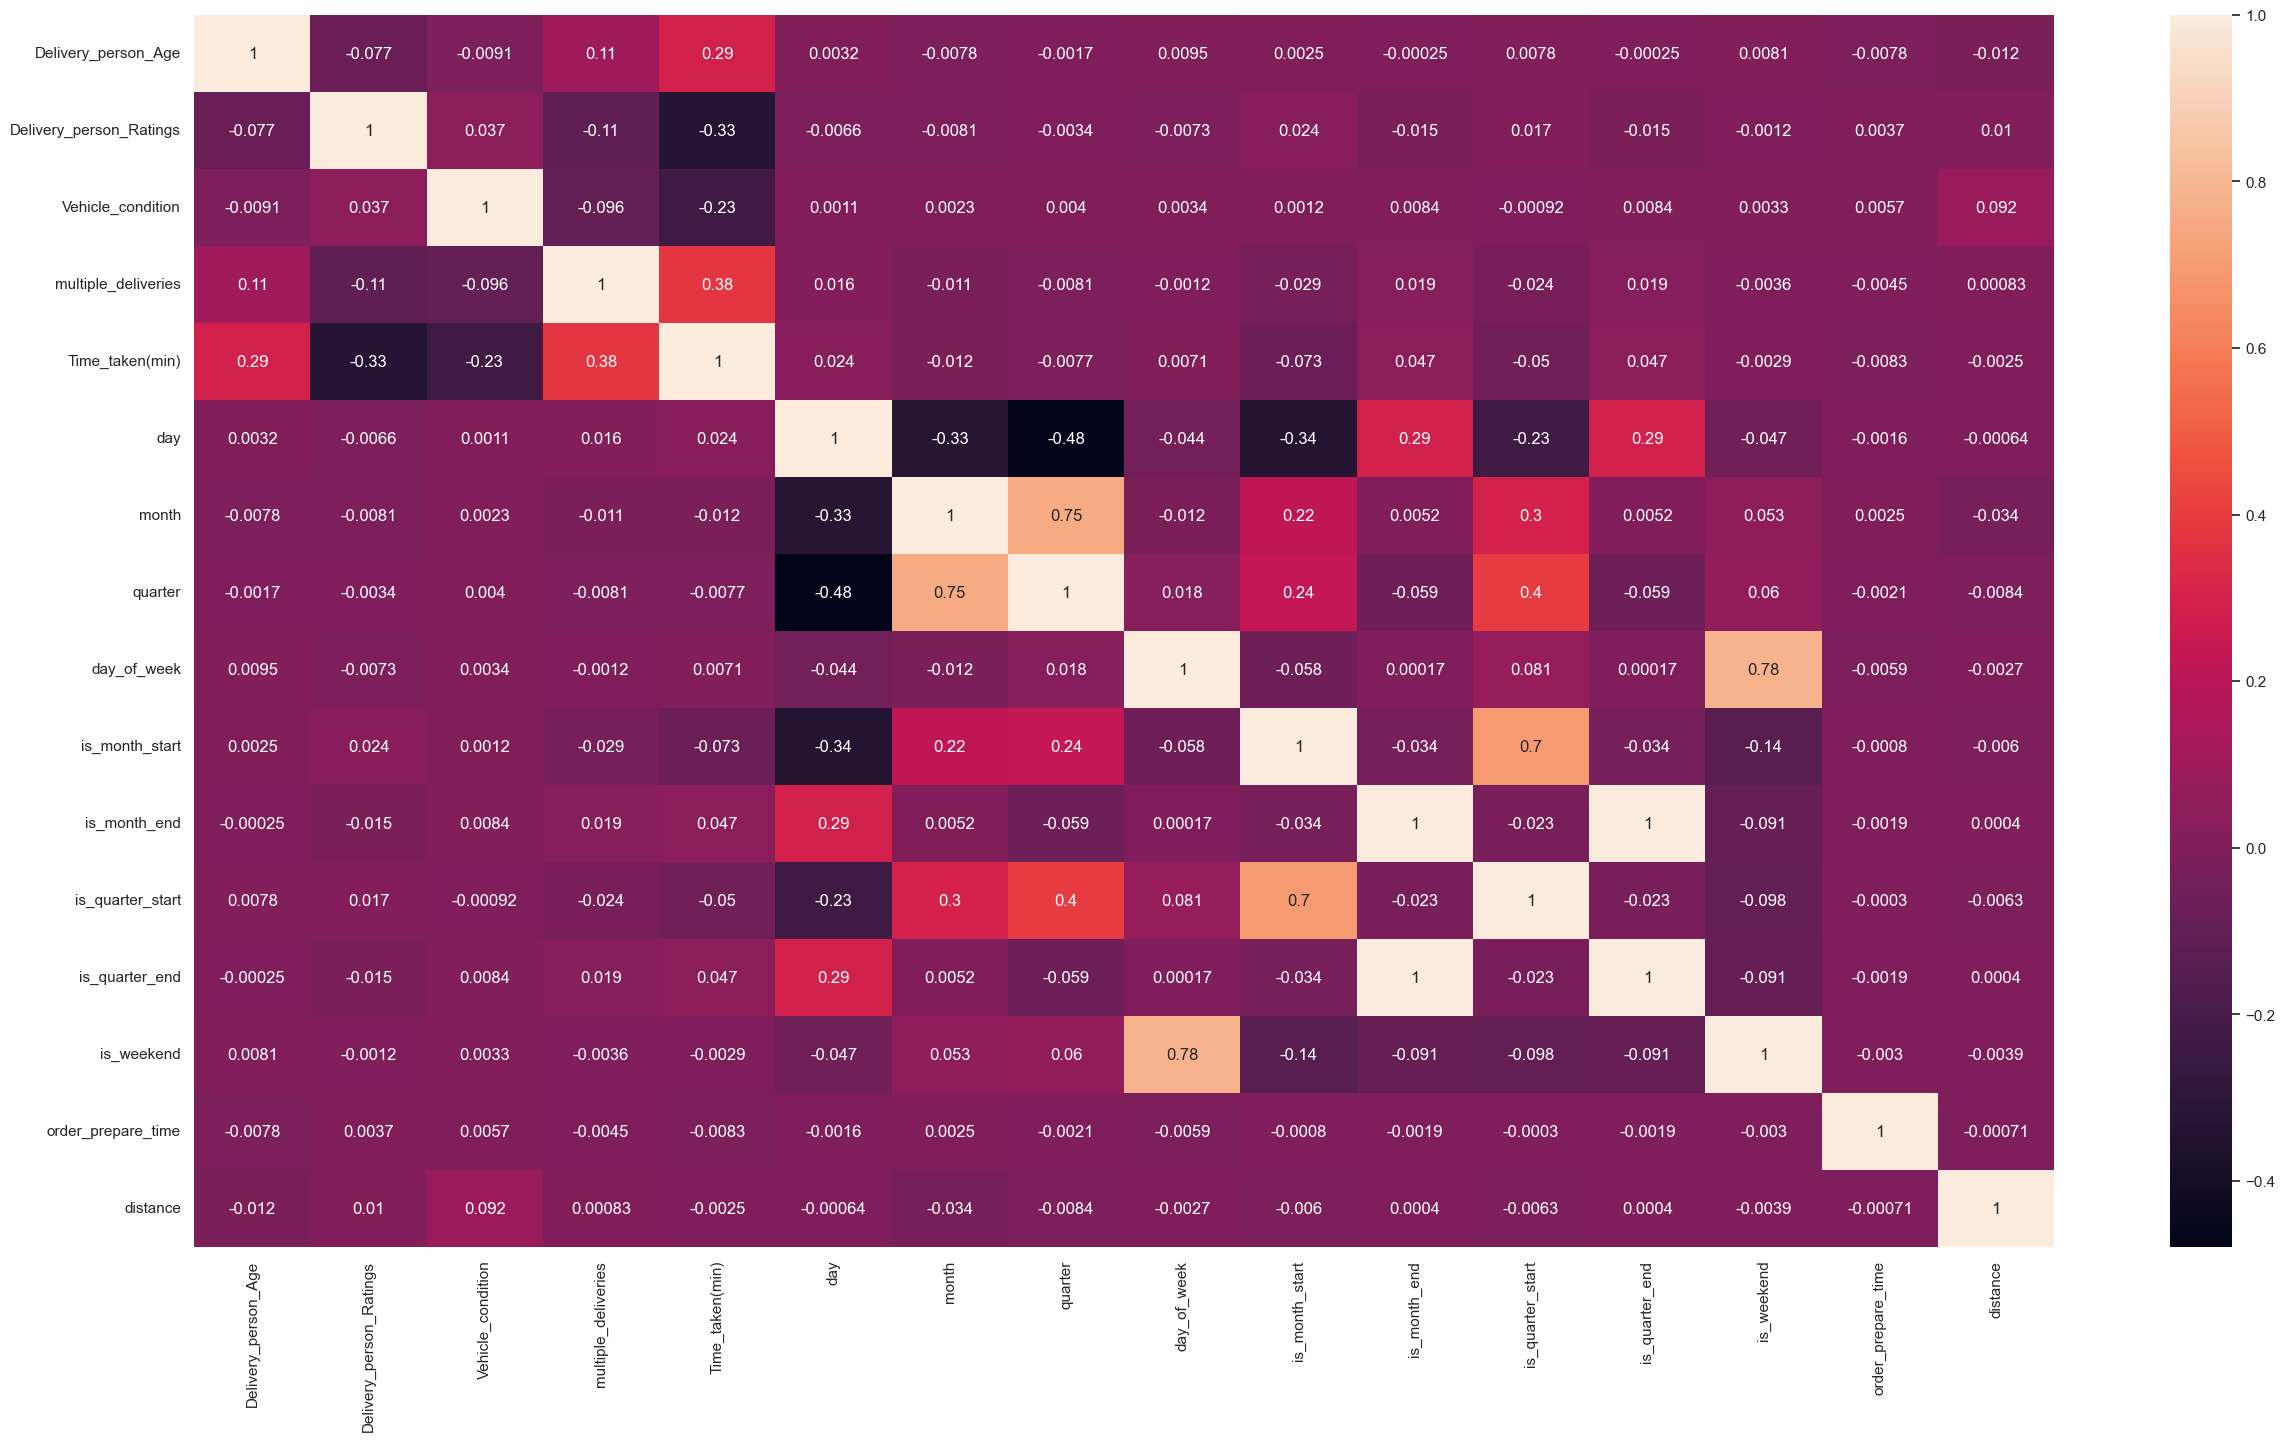

In [41]:
sns.heatmap(num_attributes2.corr(method = 'pearson'), annot = True)

## 5.0 Modelagem de Dados

In [42]:
df5 = df4.copy()

### 5.1 Normalização Z-Score

In [75]:
def normalizacao(df,col):
    mean_val = df[col].mean()
    std_val = df[col].std()
    df[col] = (df[col] - mean_val) / std_val
    return df

In [76]:
#normalizando a coluna Delivery_person_Ratings:

df_norm = normalizacao(df5, 'Delivery_person_Ratings')

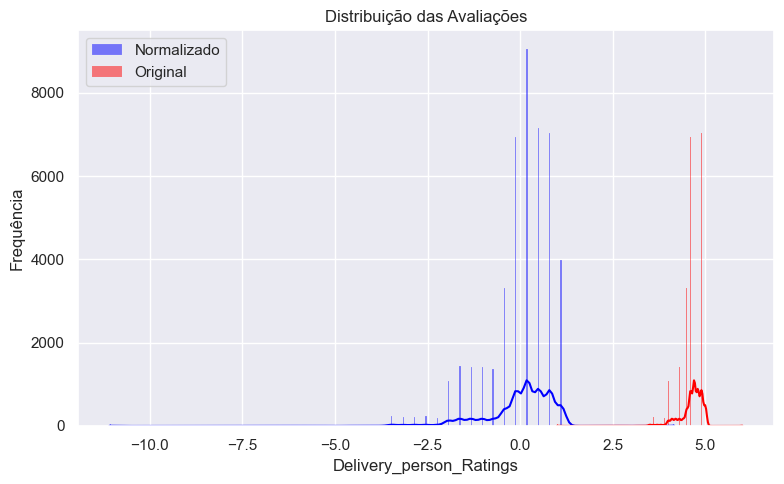

In [77]:
plt.figure(figsize=(8, 5))

# Histograma normalizado
sns.histplot(df_norm['Delivery_person_Ratings'], kde=True, color='blue', label='Normalizado', alpha=0.5)

# Histograma original (supondo que você tenha df_original ou similar)
sns.histplot(df4['Delivery_person_Ratings'], kde=True, color='red', label='Original', alpha=0.5)

plt.title('Distribuição das Avaliações')
plt.xlabel('Delivery_person_Ratings')
plt.ylabel('Frequência')
plt.legend()
plt.tight_layout()
plt.show()

### 5.2 Rescaling

In [43]:
#Min-Max Scaling:
def rescale_col(df, col):
    min_val = df[col].min()
    max_val = df[col].max()
    df[col] = (df[col] - min_val) / (max_val - min_val)
    return df

#Robust Scaling:
def robust_scale(df,col):
    scaler = RobustScaler()
    df[col] = scaler.fit_transform(df[col])
    return df

In [44]:
def rescale_column(data,column):
    scaler = MinMaxScaler()
    data[[column]] = scaler.fit_transform(data[[column]])
    pickle.dump(scaler, open('../parameter/'+column+'_scaler.pkl', 'wb'))
    return data

def robust_scale(data,column):
    scaler = RobustScaler()
    data[column] = scaler.fit_transform(data[[column]])
    pickle.dump(scaler, open('../parameter/'+column+'_scaler.pkl', 'wb'))
    return data

In [45]:
#variáveis numéricas:

num_attributes5 = df5.select_dtypes(include = ['int64', 'float64', 'int32'])
num_attributes5.columns

Index(['Delivery_person_Age', 'Delivery_person_Ratings', 'Vehicle_condition',
       'multiple_deliveries', 'Time_taken(min)', 'day', 'month', 'quarter',
       'year', 'day_of_week', 'is_month_start', 'is_month_end',
       'is_quarter_start', 'is_quarter_end', 'is_year_start', 'is_year_end',
       'is_weekend', 'order_prepare_time', 'distance'],
      dtype='object')

In [46]:
#colunas que serão rescaladas, sem as colunas booleanas:
num_cols = ['Delivery_person_Age', 'Delivery_person_Ratings', 'Vehicle_condition',
       'multiple_deliveries', 'day', 'month', 'quarter',
       'day_of_week', 'order_prepare_time', 'distance']

#fazendo o rescaling nas colunas numéricas:
for i in num_cols:
    df5 = rescale_column(df5,i)

### 5.3 Variável Resposta

In [47]:
df5['Time_taken(min)'] = np.log1p(df5['Time_taken(min)'])

### 5.4 Encoding:


In [48]:
df6 = df5.drop(columns= ['Delivery_person_ID'])

In [49]:
#Label Encoding:
def label_encoding(df,col):
    label_encoder = LabelEncoder()
    df[col] = label_encoder.fit_transform(df[col])
    pickle.dump(label_encoder, open('../parameter/'+col+'_label_encoder.pkl', 'wb'))
    return df

In [50]:
#Ordinal Encoding:
ordem_cat = {'Low': 1,
             'Medium': 2,
             'High': 3,
             'Jam': 4}

df6['Road_traffic_density'] = df6['Road_traffic_density'].map(ordem_cat)

In [51]:
#Demais variáveis categóricas:
cat_df6 = df6.select_dtypes(include = ['object'])

#colunas:
cat_columns = cat_df6.columns

#aplicando o Label Encoding:
for i in cat_columns:
    df6 = label_encoding(df6,i)

## 6.0 Seleção de Atributos

In [52]:
df7 = df6.copy()

In [ ]:
#Separando em treino e teste:

X = df7.drop(columns= ['Time_taken(min)'])
y = df7['Time_taken(min)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)

### 6.1 Feature Importance - Floresta Aleatória

In [148]:
#instanciando o modelo:
model = RandomForestRegressor()

#treinando o modelo:
model.fit(X_train, y_train)

#verificando as importâncias das features:
importances = model.feature_importances_

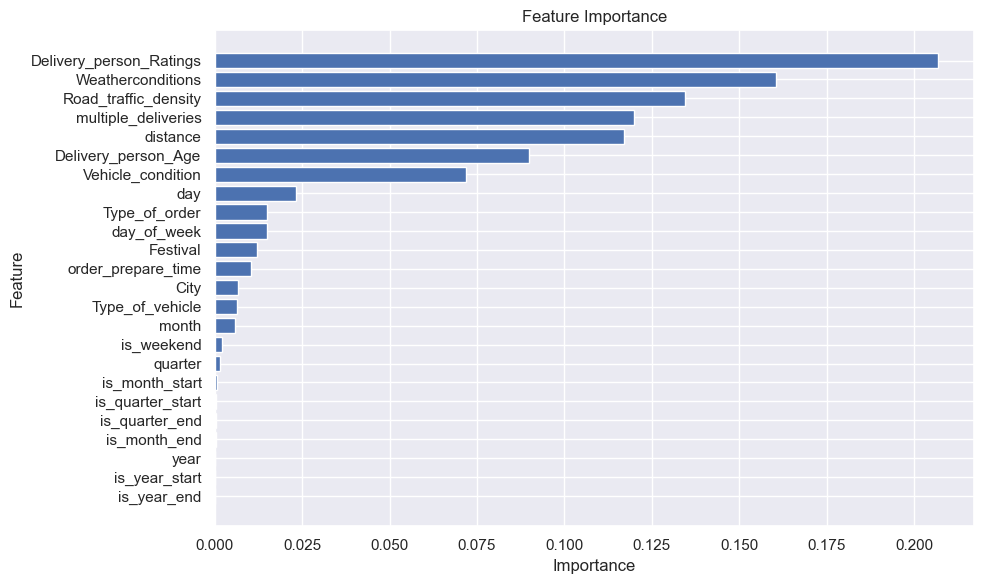

In [153]:
#Nome das variáveis:
feature_names = X_train.columns 

#Ordenando as importâncias e os nomes das variáveis:
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Gráfico de barras horizontais:
plt.figure(figsize=(10,6))
plt.barh(range(len(sorted_importances)), sorted_importances[::-1], color='b', align='center')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names[::-1])

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')

plt.tight_layout()
plt.show()

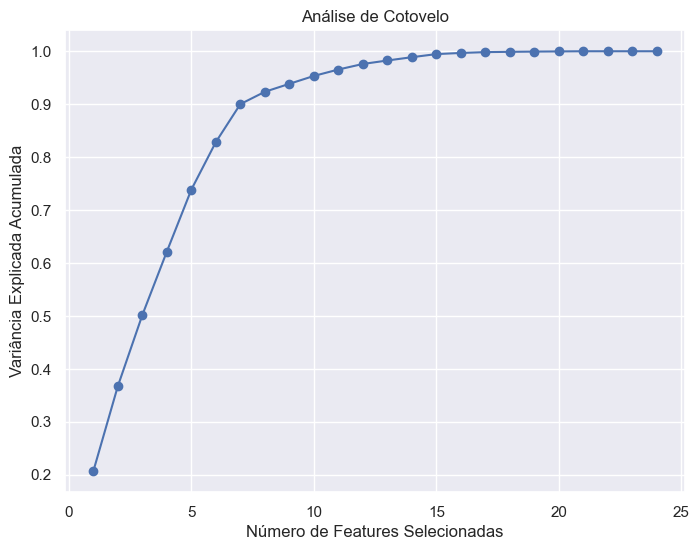

In [156]:
#Análise de cotovelo:

num_features = len(importances)

plt.figure(figsize=[8,6])
plt.plot(range(1,num_features +1), np.cumsum(sorted_importances), marker = 'o', linestyle ='-')
plt.xlabel('Número de Features Selecionadas')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Análise de Cotovelo')
plt.grid(True)
plt.show()

### 6.2 Regularização

#### 6.2.1 Regularização Lasso (L1)

In [158]:
lasso_model = Lasso(alpha=0.005, random_state=42)
lasso_model.fit(X_train, y_train)

Lasso(alpha=0.005, random_state=42)

In [160]:
select_model = SelectFromModel(lasso_model)
select_model.fit(X_train, y_train)

SelectFromModel(estimator=Lasso(alpha=0.005, random_state=42))

In [162]:
select_features = X_train.columns[select_model.get_support()]
print(select_features)

Index(['Delivery_person_Age', 'Weatherconditions', 'Road_traffic_density',
       'Vehicle_condition', 'Type_of_vehicle', 'multiple_deliveries',
       'Festival', 'City'],
      dtype='object')


### 6.3 BORUTA

In [165]:
rf = RandomForestRegressor(n_jobs = -1)
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train.values, y_train.values.ravel())

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	7
Tentative: 	0
Rejected: 	17


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	7
Tentative: 	0
Rejected: 	17


In [166]:
cols_selected = boruta.support_.tolist()
cols_selected_boruta = X_train.iloc[:, cols_selected].columns.tolist()
cols_selected_boruta

['Delivery_person_Age',
 'Delivery_person_Ratings',
 'Weatherconditions',
 'Road_traffic_density',
 'Vehicle_condition',
 'multiple_deliveries',
 'distance']

## 7.0 Machine Learning Models

In [53]:
df8 = df7.copy()

In [54]:
X = df8[['Delivery_person_Age',
 'Delivery_person_Ratings',
 'Weatherconditions',
 'Road_traffic_density',
 'Vehicle_condition',
 'multiple_deliveries',
 'distance']]
y = df8['Time_taken(min)']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.15, stratify=y, random_state=42)

### Funções:

In [210]:
#Métricas:

def calculate_regression_metrics(nome_algoritmo, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    df = pd.DataFrame({
        'Algoritmo': [nome_algoritmo],
        'MAE': [mae],
        'MSE': [mse],
        'RMSE': [rmse]
    })

    return df

def regression_metrics(y_true, y_pred, model):
    """
    Calcula métricas de desempenho para um modelo de regressão

    Parâmetros:
        y_true (array-like): valores reais
        y_pred (array-like): valores preditos pelo modelo

    Retorna:
        dict: um dicionário contendo as métricas de desempenho calculadas.
    """

    metrics = {}

    #calcular as métricas:
    metrics['Mean Absolute Error'] = mean_absolute_error(y_true, y_pred)
    metrics['Mean Absolute Percentage Error'] = np.mean(np.abs((y_true - y_pred)/y_true))*100
    metrics['Root Mean Squared Error'] = np.sqrt(mean_squared_error(y_true, y_pred))
    metrics['Model'] = model

    return pd.DataFrame(metrics, index = [0])

def regression_models(X_train, X_test, y_train, y_test):
    """
    Implementa vários modelos de regressão, 
    calcula métricas de desempenho e 
    concatena os resultados em um DataFrame.

    Parâmetros:
        X_train (array-like): Conjunto de treinamento de features
        X_test (array-like): Conjunto de teste de features
        y_train (array-like): Rótulos de treinamento
        y_test (array-like): Rótulos de teste

    Retorna:
        DataFrame: Um DataFrame contendo as métricas de
        desempenho para todos os modelos.
    """

    models = {
        'Linear Regression': LinearRegression(),
        'Decision Tree': DecisionTreeRegressor(),
        'Random Forest': RandomForestRegressor(),
        'K-Nearest Neighbors': KNeighborsRegressor(),
        'Support Vector Regression': SVR(),
        'Multi-layer Perceptron': MLPRegressor(),
        'LigthGBM': LGBMRegressor()        
    }

    results = []

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        metrics = regression_metrics(np.expm1(y_test), np.expm1(y_pred), name)
        results.append(metrics)
    
    return pd.concat(results, ignore_index = True)

def regression_cross_validation(X, y, n_splits = 5):
    """
    Função para realizar a validação cruzada de regressão

    Parâmetros:
        X: conjunto de características
        y: conjunto de rótulos
        n_splits (opcional): número de divisões para a validação cruzada
    
    Retorna:
        DataFrame: um DataFrame contendo as métricas de desempenho para cada fold
    """
    kf = KFold(n_splits = n_splits)
    results = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model_results = regression_models(X_train, X_test, y_train, y_test)
        results.append(model_results)

    return pd.concat(results, ignore_index = True)

### 7.1 Regressão Linear

In [192]:
#definiindo o modelo:
lr = LinearRegression()

#treinamento:
lr.fit(X_train, y_train)

#previsões:
y_pred = lr.predict(X_test)

In [193]:
metricas_lr = calculate_regression_metrics('Linear Regression', np.expm1(y_test), np.expm1(y_pred))
metricas_lr

Algoritmo       MAE        MSE      RMSE
0  Linear Regression  5.428987  46.949512  6.851971

### 7.2 Random Forest Regressor

In [194]:
#definiindo o modelo:
rf = RandomForestRegressor()

#treinamento:
rf.fit(X_train, y_train)

#previsões:
y_pred = rf.predict(X_test)

In [195]:
metricas_rf = calculate_regression_metrics('Random Forest Regressor', np.expm1(y_test), np.expm1(y_pred))
metricas_rf

Algoritmo       MAE        MSE      RMSE
0  Random Forest Regressor  3.376244  18.697098  4.324014

### 7.3 Cross - Validation

In [211]:
metrics = regression_cross_validation(X,y,n_splits=5)

In [212]:
metrics.groupby('Model').mean().reset_index().sort_values('Root Mean Squared Error')

Model  Mean Absolute Error  Mean Absolute Percentage Error  Root Mean Squared Error
2                   LigthGBM             3.197319                       13.528277                 4.044004
5              Random Forest             3.371962                       14.336420                 4.348604
1        K-Nearest Neighbors             4.180938                       17.470874                 5.466482
0              Decision Tree             4.138177                       17.615523                 5.469915
4     Multi-layer Perceptron             4.652843                       19.295953                 5.927280
6  Support Vector Regression             4.729546                       20.280091                 6.062608
3          Linear Regression             5.428760                       22.988972                 6.852729

## 8.0 Fine Tuning

In [213]:
param_grid = {
    'learning_rate' : [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'num_leaves': [20, 30, 40],
    'max_depth': [5, 10, -1],
    'min_child_samples': [20, 30, 50],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

### 8.1 Grid Search

#instanciando o modelo:
lgbm = LGBMRegressor(random_state=42)

#grid Search:
grid_search = GridSearchCV(estimator = lgbm, param_grid= param_grid, cv = 2, verbose = 1)

#treinando o modelo:
grid_search.fit(X_train, y_train)

In [217]:
#Melhores parâmetros:
print(grid_search.best_params_)

{'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 20, 'n_estimators': 200, 'num_leaves': 40, 'subsample': 0.6}


### 8.2 Random Search

In [219]:
#instanciando:
random_search = RandomizedSearchCV(estimator=lgbm, 
                                   param_distributions=param_grid, 
                                   n_iter=100, 
                                   cv =2, 
                                   scoring = 'neg_mean_absolute_error',
                                   n_jobs = -1, 
                                   verbose = 1)

#treinando:
random_search.fit(X_train, y_train)

#Melhores parâmetros:
print('Melhores Parâmetros:')
print(random_search.best_params_)

Fitting 2 folds for each of 100 candidates, totalling 200 fits
Melhores Parâmetros:
{'subsample': 0.8, 'num_leaves': 40, 'n_estimators': 100, 'min_child_samples': 50, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


### 8.3 Bayes Search

#### 8.3.1 Funções:

In [242]:
def lgbm_cv(learning_rate, n_estimators, max_depth, subsample, colsample_bytree, min_child_samples, num_leaves):
    params = {'learning_rate': learning_rate, 
              'n_estimators': int(n_estimators), 
              'max_depth': int(max_depth), 
              'subsample': subsample, 
              'colsample_bytree': colsample_bytree,
              'min_child_samples': int(min_child_samples), 
              'num_leaves': int(num_leaves)
              }
    
    lgbm = LGBMRegressor(**params)
    cv_results = cross_val_score(lgbm, X_train, y_train, cv = 5, scoring = 'neg_mean_absolute_error').mean()
    return cv_results


def treinar_e_avaliar(df_parametros, linha, X_train, X_test, y_train, y_test, revert_log=True):
    # Extrai os parâmetros da linha do DataFrame
    linha_parametros = df_parametros.iloc[linha]
    nome = linha_parametros['Fine Tuning']
    
    # Remove a coluna 'Fine Tuning' e converte para dicionário
    params = linha_parametros.drop('Fine Tuning').to_dict()

    # Converte os parâmetros que precisam ser inteiros
    int_keys = ['n_estimators', 'num_leaves', 'max_depth', 'min_child_samples']
    for key in int_keys:
        if key in params:
            params[key] = int(params[key])

    # Treina o modelo
    modelo = LGBMRegressor(**params, random_state=42)
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    # Reverte log1p se necessário
    if revert_log:
        y_test_eval = np.expm1(y_test)
        y_pred_eval = np.expm1(y_pred)
    else:
        y_test_eval = y_test
        y_pred_eval = y_pred

    # Calcula métricas
    r2 = r2_score(y_test_eval, y_pred_eval)
    mae = mean_absolute_error(y_test_eval, y_pred_eval)
    rmse = np.sqrt(mean_squared_error(y_test_eval, y_pred_eval))

    return {
        'Fine Tuning': nome,
        'R²': r2,
        'MAE': mae,
        'RMSE': rmse
    }

#Aumentando os limites de busca dos hiperparâmetros:
pbounds = {
    'learning_rate' : (0.01, 0.5),
    'n_estimators': (50, 1000),
    'num_leaves': (10, 100),
    'max_depth': (3, 20),
    'min_child_samples': (10, 100),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0)
}

#Configurando a optimização bayesiana
optmizer = BayesianOptimization(
    f=lgbm_cv,
    pbounds=pbounds,
    random_state=42
)

#executando a otimização:
optmizer.maximize(init_points=5, n_iter=50)

#melhores parâmetros:
print('Melhores Parâmetros: ')
print(optmizer.max)

### 8.4 Parâmetros:

In [231]:
df_gridsearch = pd.DataFrame([grid_search.best_params_])
df_gridsearch['Fine Tuning'] = 'Grid Search'

df_randomrearch = pd.DataFrame([random_search.best_params_])
df_randomrearch['Fine Tuning'] = 'Random Search'

df_bayessearch = pd.DataFrame([optmizer.max['params']])
df_bayessearch['Fine Tuning'] = 'Bayes Search'

parametros = pd.concat([df_gridsearch, df_randomrearch, df_bayessearch])

cols = ['Fine Tuning'] + [col for col in parametros.columns if col != 'Fine Tuning']
parametros = parametros[cols]

parametros

Fine Tuning  colsample_bytree  learning_rate  max_depth  min_child_samples  n_estimators  num_leaves  subsample
0    Grid Search          1.000000           0.05  -1.000000          20.000000    200.000000   40.000000   0.600000
0  Random Search          0.800000           0.10  10.000000          50.000000    100.000000   40.000000   0.800000
0   Bayes Search          0.879128           0.01  17.091435          38.010375    605.734925   84.368745   0.766222

### 8.5 Métricas:

In [241]:
resultados = []
for i in range(len(parametros)):
    resultado = treinar_e_avaliar(parametros, i, X_train, X_test, y_train, y_test)
    resultados.append(resultado)

df_resultados = pd.DataFrame(resultados)
df_resultados

Fine Tuning        R²       MAE      RMSE
0    Grid Search  0.818893  3.169543  3.994313
1  Random Search  0.818541  3.170524  3.998186
2   Bayes Search  0.821319  3.140510  3.967462

In [244]:
best_params = {'learning_rate': 0.01, 
               'n_estimators': 605, 
               'num_leaves': 84, 
               'max_depth': 17, 
               'min_child_samples': 38, 
               'subsample': 0.7662221880367187, 
               'colsample_bytree': 0.8791280764949503}

## 9.0 Error Analysis

In [246]:
lgbm_model = LGBMRegressor(**best_params)
lgbm_model.fit(X_train, y_train)
y_pred = lgbm_model.predict(X_test)

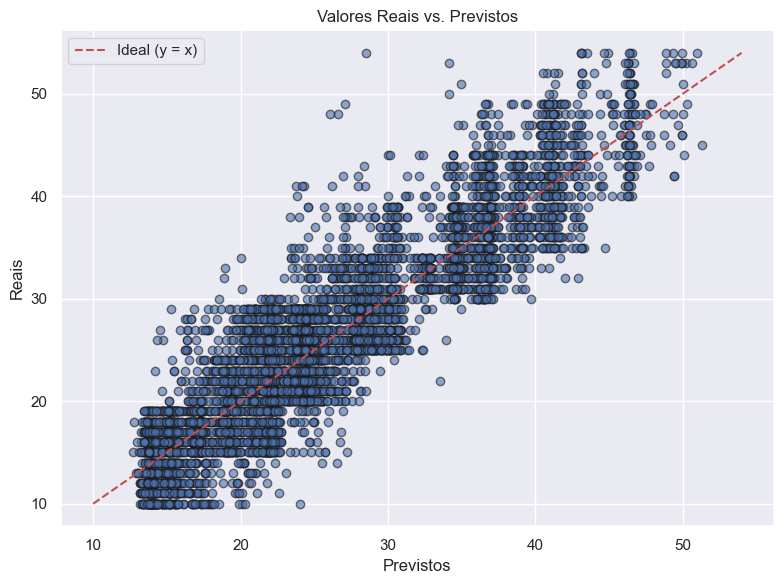

In [252]:
plt.figure(figsize=(8, 6))
plt.scatter(np.expm1(y_pred), np.expm1(y_test), alpha=0.6, edgecolors='k')

# Linha de referência (y = x)
max_val = max(np.max(np.expm1(y_test)), np.max(np.expm1(y_pred)))
min_val = min(np.min(np.expm1(y_test)), np.min(np.expm1(y_pred)))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal (y = x)')

# Títulos e rótulos
plt.title('Valores Reais vs. Previstos')
plt.xlabel('Previstos')
plt.ylabel('Reais')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

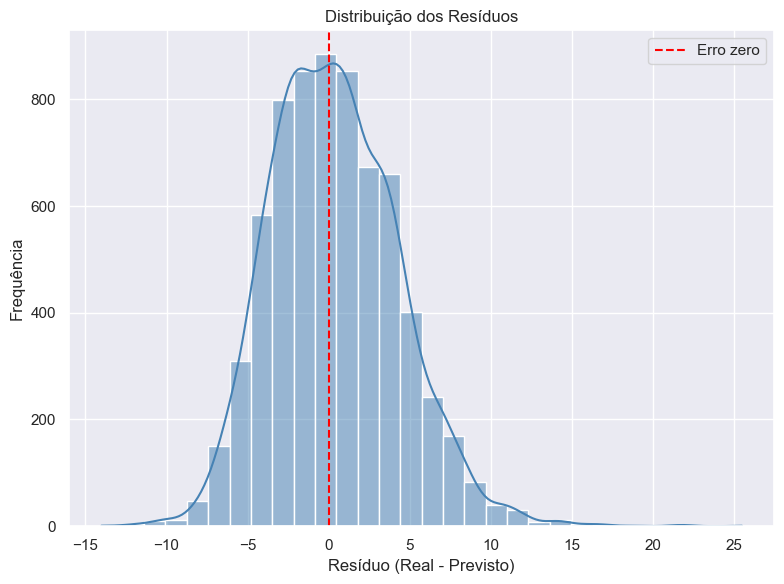

In [254]:
# Calcula os resíduos
residuos = np.expm1(y_test) - np.expm1(y_pred)

# Cria o histograma
plt.figure(figsize=(8, 6))
sns.histplot(residuos, bins=30, kde=True, color='steelblue')

# Adiciona linha vertical no zero
plt.axvline(0, color='red', linestyle='--', label='Erro zero')

# Títulos e rótulos
plt.title('Distribuição dos Resíduos')
plt.xlabel('Resíduo (Real - Previsto)')
plt.ylabel('Frequência')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 10.0 Cálculo do ROI do Projeto

In [256]:
metrics = regression_metrics(np.expm1(y_test), np.expm1(y_pred), 'LGBM')
metrics

Mean Absolute Error  Mean Absolute Percentage Error  Root Mean Squared Error Model
0             3.142546                       13.295756                  3.96955  LGBM

In [265]:
mae_atual = 10
mae_novo = 3.14
custo_cancelamento_por_minuto = 1
pedidos_diarios = 10000
tx_cancelamento_atual = 0.15

pedidos_cancelados = pedidos_diarios * tx_cancelamento_atual
delta_mae = mae_atual - mae_novo
economia_por_pedido = delta_mae * custo_cancelamento_por_minuto
economia_diaria = pedidos_cancelados * economia_por_pedido

print(f'Gasto atual com cancelamentos por dia: R$ {pedidos_cancelados * mae_atual}')
print(f'Gasto com cancelamentos por dia, com o modelo: R$ {pedidos_cancelados * mae_novo}')
print(f"Economia estimada por dia: R$ {economia_diaria:.2f}")


Gasto atual com cancelamentos por dia: R$ 15000.0
Gasto com cancelamentos por dia, com o modelo: R$ 4710.0
Economia estimada por dia: R$ 10290.00


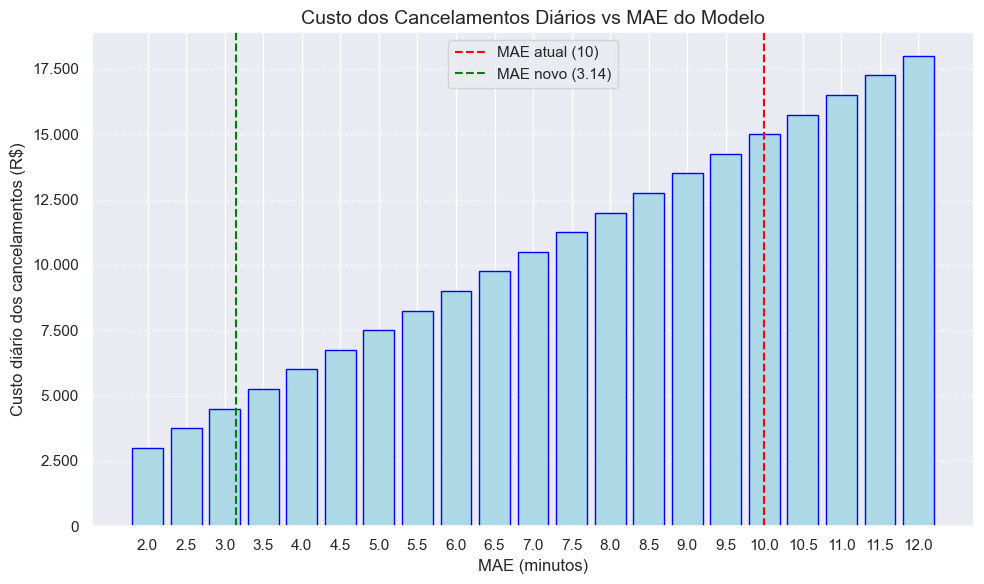

In [268]:
# Função para formatar os números com separador de milhar
def milhar(x, pos):
    return f'{int(x):,}'.replace(',', '.')

# Faixa de valores de MAE simulados
maes = np.arange(2, 12.5, 0.5)

# Cálculo do custo de cancelamento por MAE
pedidos_cancelados = pedidos_diarios * tx_cancelamento_atual
custos = pedidos_cancelados * custo_cancelamento_por_minuto * maes

# Plot do gráfico
plt.figure(figsize=(10, 6))
plt.bar(maes, custos, width=0.4, color='lightblue', edgecolor='blue')

# Destaques para os modelos atual e novo
custo_atual = pedidos_cancelados * custo_cancelamento_por_minuto * mae_atual
custo_novo = pedidos_cancelados * custo_cancelamento_por_minuto * mae_novo

plt.axvline(mae_atual, color='red', linestyle='--', label=f'MAE atual ({mae_atual})')
plt.axvline(mae_novo, color='green', linestyle='--', label=f'MAE novo ({mae_novo})')

# Títulos e rótulos
plt.title('Custo dos Cancelamentos Diários vs MAE do Modelo', fontsize=14)
plt.xlabel('MAE (minutos)', fontsize=12)
plt.ylabel('Custo diário dos cancelamentos (R$)', fontsize=12)

# Formatação do eixo Y
formatter = FuncFormatter(milhar)
plt.gca().yaxis.set_major_formatter(formatter)

plt.xticks(maes, [f'{m:.1f}' for m in maes])
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

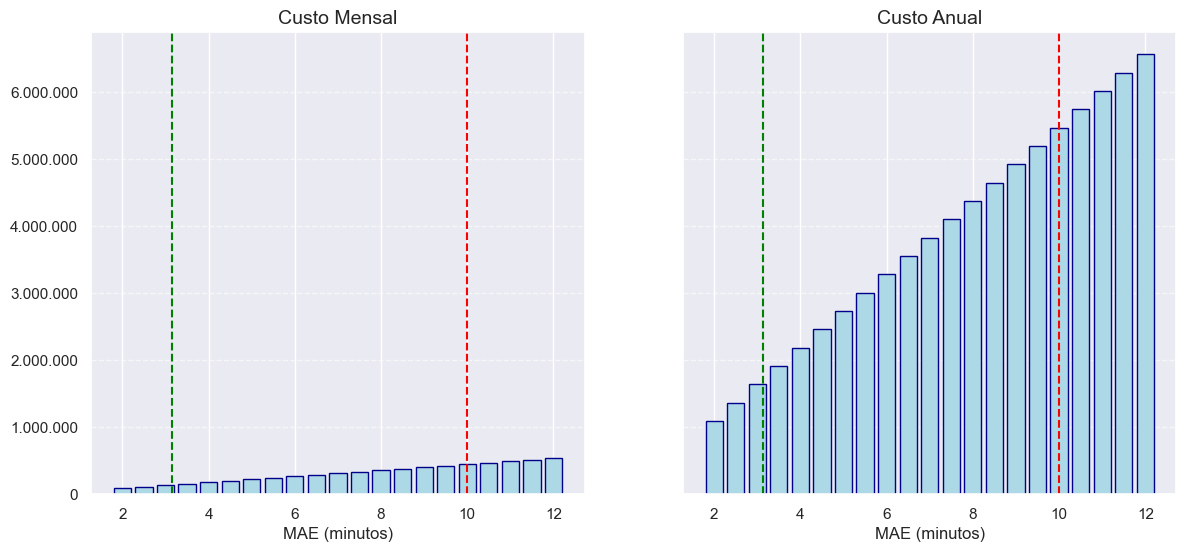

In [275]:
# Cálculo do custo mensal e anual
custos_mensais = pedidos_cancelados * custo_cancelamento_por_minuto * maes * 30
custos_anuais = pedidos_cancelados * custo_cancelamento_por_minuto * maes * 365

# Plot dos dois gráficos
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Lista de títulos e dados
titulos = ['Custo Mensal', 'Custo Anual']
custos = [custos_mensais, custos_anuais]

formatter = FuncFormatter(milhar)
axs[0].yaxis.set_major_formatter(formatter)
axs[1].yaxis.set_major_formatter(formatter)

for i in range(2):
    axs[i].bar(maes, custos[i], width=0.4, color='lightblue', edgecolor='darkblue')
    axs[i].axvline(mae_atual, color='red', linestyle='--', label=f'MAE atual ({mae_atual})')
    axs[i].axvline(mae_novo, color='green', linestyle='--', label=f'MAE novo ({mae_novo})')
    axs[i].set_title(titulos[i], fontsize=14)
    axs[i].set_xlabel('MAE (minutos)', fontsize=12)
    axs[i].grid(True, axis='y', linestyle='--', alpha=0.6)
   

## 11.0 Final Model

In [276]:
X_full = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

In [279]:
final_model = LGBMRegressor(**best_params)
final_model.fit(X_full, y_full)

LGBMRegressor(colsample_bytree=0.8791280764949503, learning_rate=0.01,
              max_depth=17, min_child_samples=38, n_estimators=605,
              num_leaves=84, subsample=0.7662221880367187)

In [281]:
pickle.dump(final_model, open('final_model.pkl', 'wb'))

## 12.0 Deploy to Production

In [80]:
import pandas as pd
import pickle
import numpy as np
import json
from geopy.distance import geodesic

In [72]:
class PredictDelivery(object):
    def __init__(self):
        self.Delivery_person_Age_scaler = pickle.load(open('../parameter/Delivery_person_Age_scaler.pkl', 'rb'))
        self.Delivery_person_Ratings_scaler = pickle.load(open('../parameter/Delivery_person_Ratings_scaler.pkl', 'rb'))
        self.Weatherconditions_label_encoder = pickle.load(open('../parameter/Weatherconditions_label_encoder.pkl', 'rb'))
        self.Vehicle_condition_scaler = pickle.load(open('../parameter/Vehicle_condition_scaler.pkl', 'rb'))
        self.multiple_deliveries_scaler = pickle.load(open('../parameter/multiple_deliveries_scaler.pkl', 'rb'))
        self.distance_scaler = pickle.load(open('../parameter/distance_scaler.pkl', 'rb'))
    
    def data_formatation(self, df):
        df['Weatherconditions'] = df['Weatherconditions'].str.strip()
        return df
    
    def calculate_time_diff(self,df):
        time_diff = df['Time_Order_picked'] - df['Time_Orderd']
        time_diff = time_diff.apply(lambda x: x + pd.Timedelta(days=1) if x.days < 0 else x)
        df['order_prepare_time'] = time_diff.dt.total_seconds() / 60
        df['order_prepare_time'].fillna(df['order_prepare_time'].median(), inplace = True)
        return df
    
    def calculate_distance(self, df):
        df['distance'] = np.zeros(len(df))
        restaurante_coordinates = df[['Restaurant_latitude','Restaurant_longitude']].to_numpy()
        cliente_coordinates = df[['Delivery_location_latitude','Delivery_location_longitude']].to_numpy()
        df['distance'] = np.array([geodesic(restaurant, delivery) for restaurant, delivery in zip(restaurante_coordinates, cliente_coordinates)])
        df['distance'] = df['distance'].astype('str').str.extract('(\d+)').astype('int64')
        return df
    
    def feature_engineering(self, df2):
        df2 = self.calculate_time_diff(df2)
        df2 = self.calculate_distance(df2)
        return df2
    
    def data_preparation(self, df3):
        df3['Delivery_person_Age'] = self.Delivery_person_Age_scaler.transform(df3[['Delivery_person_Age']])
        df3['Delivery_person_Ratings'] = self.Delivery_person_Ratings_scaler.transform(df3[['Delivery_person_Ratings']])
        df3['Vehicle_condition'] = self.Vehicle_condition_scaler.transform(df3[['Vehicle_condition']])
        df3['multiple_deliveries'] = self.multiple_deliveries_scaler.transform(df3[['multiple_deliveries']])
        df3['distance'] = self.distance_scaler.transform(df3[['distance']])
        
        ordem_categoria = {'Low': 1, 'Medium': 2, 'High': 3, 'Jam': 4}
        df3['Road_traffic_density'] = df3['Road_traffic_density'].map(ordem_categoria)

        df3['Weatherconditions'] = self.Weatherconditions_label_encoder.transform(df3[['Weatherconditions']])

        df3 = df3[['Delivery_person_Age', 'Delivery_person_Ratings', 'Weatherconditions',
                    'Road_traffic_density', 'Vehicle_condition', 'multiple_deliveries', 'distance']]     
        return df3
    
    def get_predictions(self, model, test_data, original_data):
        pred = model.predict(test_data)
        original_data['prediction'] = pred
        return original_data.to_json(orient='records')
    

In [75]:
#teste local:
pipeline = PredictDelivery()

In [ ]:
#modelo:
model = pickle.load(open('final_model.pkl', 'rb'))

#dado de teste:
test_data = df1.head(1)

In [78]:
df_format = pipeline.data_formatation(test_data)
df_feature = pipeline.feature_engineering(df_format)
df_preparation = pipeline.data_preparation(df_feature)
pred = pipeline.get_predictions(model, df_preparation, test_data)

C:\Users\samso\AppData\Local\Temp\ipykernel_24060\388410148.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Weatherconditions'] = df['Weatherconditions'].str.strip()
C:\Users\samso\AppData\Local\Temp\ipykernel_24060\388410148.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['order_prepare_time'] = time_diff.dt.total_seconds() / 60
C:\Users\samso\AppData\Local\Temp\ipykernel_24060\388410148.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See 

In [79]:
pred

'[{"ID":"0x4607 ","Delivery_person_ID":"INDORES13DEL02 ","Delivery_person_Age":0.59375,"Delivery_person_Ratings":0.78,"Restaurant_latitude":22.745049,"Restaurant_longitude":75.892471,"Delivery_location_latitude":22.765049,"Delivery_location_longitude":75.912471,"Order_Date":1647648000000,"Time_Orderd":1647689400000,"Time_Order_picked":1647690300000,"Weatherconditions":4,"Road_traffic_density":null,"Vehicle_condition":0.6666666667,"Type_of_order":"Snack ","Type_of_vehicle":"motorcycle ","multiple_deliveries":0.0,"Festival":"No ","City":"Urban ","Time_taken(min)":24,"order_prepare_time":15.0,"distance":0.0001014816,"prediction":2.6879119623}]'

## API

In [82]:
from flask import Flask, request, Response
import os
import json
import pickle 
import pandas as pd

In [83]:
model = pickle.load(open('final_model.pkl', 'rb'))
app = Flask(__name__)

@app.route('/empresa/predict', methods = ['POST'])
def delivery_predict():
    test_json = request.get_json()

    if test_json:
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index = [0])
        else: test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

        pipeline = PredictDelivery()

        df_format = pipeline.data_formatation(test_raw)
        df_feature = pipeline.feature_engineering(df_format)
        df_preparation = pipeline.data_preparation(df_feature)
        df_predict = pipeline.get_predictions(model, df_preparation, test_raw)
        return df_predict
    
    else:
        return Response('{}', status = 200, mimetype='aplication/json')
    
if __name__ == '__main__':
    port = os.environ.get('PORT', 5000)
    app.run('0.0.0.0', port = port)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.0.4:5000
Press CTRL+C to quit


In [102]:
import json
import requests

url = 'http://127.0.0.1:5000/empresa/predict'
header = {'Content-type': 'application/json'}
data_test = df1.head(1)
data = json.dumps(data_test.to_dict(orient = 'records'))

r = requests.post(url, data=data, headers=header)

In [103]:
r.json()

JSONDecodeError: Expecting value: line 1 column 1 (char 0)